In [1]:
# 1. initial module
#初始化模块 
%matplotlib notebook
import torch
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from scipy import io
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib.pyplot import MultipleLocator

torch.set_printoptions(precision=15)
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

False


In [2]:
### 2. user's setting
## There exists two settings for delta1, if delta1=0.5/segm, in the latter block please set shwtyp=False, otherwise shwtyp=True
dataFile = '.\\data\\pca14.mat'
mat = io.loadmat(dataFile)
datarec=mat['score']
datarec=torch.from_numpy(datarec).float();

dim=14;
learning_rate = 1e-3
segm=3
delta1=0.5/segm
#delta1=1/segm
lastloss=0;
ss=2
sstr=1
del2=1

num_of_tr=5
tr_num_learn=0 # the trace need to be learnt

rec=[0,3137,6271,9330,12641,15662]
recn=[]
for k in range(num_of_tr):
    recn.append(rec[k+1]-rec[k])

print(datarec[0:1]);

for k in range(num_of_tr):
    name="data"+'%d' %k
    locals()[name]=datarec[rec[k]:rec[k+1],0:dim]
#     locals()[name]=locals()[name].to(dev)

reclen=torch.tensor([rec[i+1]-rec[i] for i in range(5)])

## compute the smooth data trace
scoe=1
for k in range(num_of_tr):
    name="data"+'%d' %k
    locals()["ave"+name]=(scoe*locals()[name][0:reclen[k]-2]+\
                          locals()[name][1:reclen[k]-1]+\
                          scoe*locals()[name][2:reclen[k]])/(2*scoe+1)

## prepare for training
name="data"+'%d' %tr_num_learn
x_start=locals()[name][0:reclen[tr_num_learn]-ss-1]
x_target=torch.zeros(reclen[tr_num_learn]-ss-1,dim,ss)
for k in range(ss):
    x_target[:,:,k]= locals()["ave"+name][k:reclen[tr_num_learn]-ss-1+k]
train_ds = TensorDataset(x_start, x_target)
bt_size=150
datatr_loader = DataLoader(train_ds, batch_size=bt_size,shuffle=True)

loss_fn = torch.nn.MSELoss(reduction='sum')


tensor([[-0.404950469732285, -0.125637084245682,  0.290102809667587,
          0.176704913377762, -0.145935639739037,  0.068543523550034,
         -0.040213689208031, -0.000506849726662, -0.037676446139812,
         -0.123931199312210,  0.067150823771954,  0.015110116451979,
          0.020249528810382, -0.002167134778574]])


In [4]:
# 3. loading data module
#载入数据的预备工作

def loadcoe(names,iscuda):
    dataFile = '.\\data\\'+names+'.mat'#replace with your path of data
    locals()["mat"+names] = io.loadmat(dataFile)
    locals()[names]=locals()["mat"+names][names]/1.0
    locals()[names]=torch.from_numpy(locals()[names]).float();
    if iscuda:
        return(locals()[names].to(dev))
    else:
        return(locals()[names])
    
dataFile = '.\\data\\traa.mat'#replace with your path of data
mat1 = io.loadmat(dataFile)
traa=mat1['traA']
traa=torch.from_numpy(traa).float();

dataFile = '.\\data\\trab.mat'#replace with your path of data
mat1 = io.loadmat(dataFile)
trab=mat1['traB']
trab=torch.from_numpy(trab).float();

for (names,iscu) in [
    ('cc0',False),('state1',False),('state2',False),('state3',False),
    ('state4',False),('state5',False),("fpsarr",False),]:
    locals()[names]=loadcoe(names,iscu)

# for (names,iscu) in [
#     ("strec",True),("stnum",True),
#     ("stcogo",True),("stconu",True),("stcoar",True),("starr",True),
#     ("stgosorted",True)]:
#     locals()[names]=loadcoe(names,iscu)

fpsarr=fpsarr.squeeze(1)
nename=["AIBL","AIBR","ALA","AVAL","AVAR","AVBL","AVBR","AVER","RIBL","RID","RIML","RIMR","RIVL","RIVR"]

colorname=["red","orange","yellow","green","blue","blue","pink","grey"]
colorname2=[(212/255, 76/255, 60/255),(255/255, 158/255, 2/255),(162/255, 202/255, 106/255),(43/255, 173/255, 109/255),(75/255, 116/255, 178/255),(75/255, 116/255, 178/255),(88/255,42/255,110/255),(0.4,0.4,0.4)];
fps=2.904629629629630

statename=['Forward','Slow','Dorsal turn','Ventral turn',' Reverse',' Reverse','Sustained reverse','NOSTATE']
staten=["Forward","Slow","D turn","V turn","Reverse","Reverse","S reverse"]
leishu=[55,61,34,124,47,61,80,3];
cumleishu=torch.zeros(9)
cumleishu[0]=0
for k in range(8):
    cumleishu[k+1]=cumleishu[k]+leishu[k]

cumleishu=cumleishu.clone().type(torch.int)

for k in range(num_of_tr):
    name="state"+'%d' %(k+1)
    locals()[name]=locals()[name].clone().type(torch.int)
    locals()[name]=locals()[name][0]
print(state1)
print(state2)

tensor([2, 2, 2,  ..., 1, 1, 2], dtype=torch.int32)
tensor([2, 2, 7,  ..., 2, 2, 2], dtype=torch.int32)


In [5]:
# 4. learning module
# 学习模块  
loss_rec=[]
model = torch.nn.Sequential(
    torch.nn.Linear(dim, 120),
    torch.nn.ReLU(False),
    torch.nn.Linear(120, 120),
    torch.nn.ReLU(False),
    torch.nn.Linear(120,120),
    torch.nn.Sigmoid(),#
    torch.nn.Linear(120, dim),
#     torch.nn.Flatten(0, 10)
)
model.to(dev)

# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()



for epoch in range(200):
    for xpre,xtar in datatr_loader:
        xpre=xpre.to(dev)
        xtar=xtar.to(dev)
        for k in range(ss):
            for j in range(segm):
                xpre=xpre+(model(xpre)-xpre*del2)*delta1/fpsarr[tr_num_learn]
            if k<sstr:
                continue
            if k==sstr:
                loss = loss_fn(xpre,xtar[:,:,k])
            else:
                loss=loss+loss_fn(xpre,xtar[:,:,k])
        
    
#     if t % 200 == 199 and lastloss < loss and learning_rate > 1e-8:
#         learning_rate = learning_rate/1.4
#         optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_rec.append(loss)
    if epoch % 10 == 9:
        print(epoch, loss.item(),learning_rate)
        
    if epoch% 50 ==49:
        lastloss=loss

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()


9 4.748398303985596 0.001
19 4.025664806365967 0.001
29 3.1794731616973877 0.001
39 2.4572417736053467 0.001
49 2.0911381244659424 0.001
59 1.6836082935333252 0.001
69 1.447516679763794 0.001
79 1.3845881223678589 0.001
89 1.3103832006454468 0.001
99 1.291567325592041 0.001
109 1.1785609722137451 0.001
119 1.1476048231124878 0.001
129 0.8129825592041016 0.001
139 0.7736927270889282 0.001
149 0.8128892183303833 0.001
159 0.6905051469802856 0.001
169 0.680067777633667 0.001
179 0.7010546922683716 0.001
189 0.6474772095680237 0.001
199 0.6969689130783081 0.001


In [5]:
# 5. adjust lr
learning_rate = learning_rate/10

In [6]:
# 6. longer learning module
# 补充学习模块
for epoch in range(6000):
    for xpre,xtar in datatr_loader:
        xpre=xpre.to(dev)
        xtar=xtar.to(dev)
        for k in range(ss):
            for j in range(segm):
                xpre=xpre+(model(xpre)-xpre*del2)*delta1/fpsarr[tr_num_learn]
            if k<sstr:
                continue
            if k==sstr:
                loss = loss_fn(xpre,xtar[:,:,k])
            else:
                loss=loss+loss_fn(xpre,xtar[:,:,k])
        
    
#     if t % 200 == 199 and lastloss < loss and learning_rate > 1e-8:
#         learning_rate = learning_rate/1.4
#         optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    if epoch % 100 == 99:
        print(epoch, loss.item(),learning_rate)
        
    if epoch% 50 ==49:
        lastloss=loss

    loss.backward()
    loss_rec.append(loss)

    optimizer.step()

    optimizer.zero_grad()

99 0.6715718507766724 0.0001
199 0.569061815738678 0.0001
299 0.5424953699111938 0.0001
399 0.4915361702442169 0.0001
499 0.5149476528167725 0.0001
599 0.5272077918052673 0.0001
699 0.4690384566783905 0.0001
799 0.4036361575126648 0.0001
899 0.4255823493003845 0.0001
999 0.4008597433567047 0.0001
1099 0.3818420171737671 0.0001
1199 0.3736571967601776 0.0001
1299 0.4580664038658142 0.0001
1399 0.3805275559425354 0.0001


KeyboardInterrupt: 

In [6]:
# 7. print loss part1
for i in range(len(loss_rec)):
    loss_rec[i]=loss_rec[i].item()

<IPython.core.display.Javascript object>


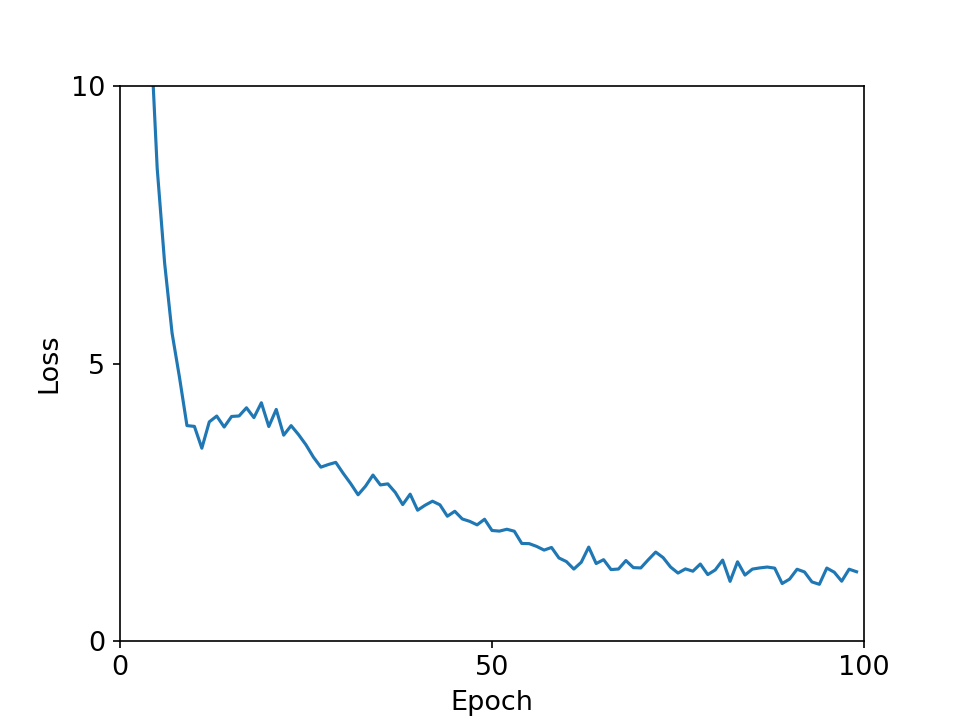

(0.0, 100.0)

In [7]:
# 8. print loss part2
len(loss_rec)
figloss=plt.figure(1612)
loss_xlabel=100
# plt.plot(range(len(loss_rec)),loss_rec)
plt.plot(range(loss_xlabel),loss_rec[1:loss_xlabel+1])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Epoch",fontsize=13)
plt.ylabel("Loss",fontsize=13)

ax=plt.gca()
ax.set_xticks([0, loss_xlabel/2, loss_xlabel])# fig3ar f1a f4a f4c
ax.set_yticks([0,5,10])# fig3ar f1a f2e1 f4a f4c

plt.ylim(0,10) # fig3ar f1a f2e1 f4a f4c
plt.xlim(0,loss_xlabel) #fig3ar f1a f4a f4c

# savefig_path="./lastout/out-ori/ex1/loss"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)
# lossmat=np.array(loss_rec)
# io.savemat("./lastout/out-ori/ex1/loss.mat",{"loss":lossmat})

In [34]:
# 9. preparation for state module
for k in range(num_of_tr):
    name="state"+'%d' %(k+1)
    locals()[name+"0"]=locals()[name].clone().type(torch.long)

print(data1.shape)
data_x=torch.tensor([])
for k in range(num_of_tr):
    name="data"+'%d' %k
    data_x=torch.cat((data_x,locals()[name]))
print(data_x.shape)
# data_x=torch.cat((data0,data1,data2,data3,data4))
# print(data_x.shape)
print(state10.shape,state2.shape)
data_st=torch.tensor([])
for k in range(num_of_tr):
    name="state"+'%d' %(k+1)
    data_st=torch.cat((data_st,locals()[name+'0']))
print(data_st.shape)
# data_st=torch.cat((state10,state20,state30,state40,state50)).squeeze()
# print(data_st.shape)

torch.Size([3134, 14])
torch.Size([15662, 14])
torch.Size([3137]) torch.Size([3134])
torch.Size([15662])


In [35]:
# 10. state learning module
# 状态模型  
loss_rec2=[]
pre_rate2=[]
learning_rate2 = 1e-2
# ind_left= state1!=8
# data0_left=data0[ind_left]
# state1_left=state1[ind_left]
ind_left= data_st!=8
data0_left=data_x[ind_left]
state1_left=data_st[ind_left]
train_ds = TensorDataset(data0_left, state1_left.clone().type(torch.long)-1)
bt_size=rec[num_of_tr]
datatr_loader = DataLoader(train_ds, batch_size=bt_size,shuffle=True)
criterion = nn.CrossEntropyLoss()

model2 = torch.nn.Sequential(
    torch.nn.Linear(dim, 120),
    torch.nn.ReLU(False),
    torch.nn.Linear(120, 120),
    torch.nn.ReLU(False),
    torch.nn.Linear(120,120),
    torch.nn.Sigmoid(),#
    torch.nn.Linear(120, 8),
#     torch.nn.Flatten(0, 10)
)
model2.to(dev)

# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate2)
optimizer.zero_grad()



for epoch in range(500):
    for xpre,xst in datatr_loader:
        xpre=xpre.to(dev)
        xst=xst.to(dev)
        output = model2(xpre)
        loss=criterion(output,xst)
        loss.backward()
        loss_rec2.append(loss)
        optimizer.step()
        optimizer.zero_grad()
        pred = output.argmax(1)
        pre_rate2.append((pred==xst).sum()/bt_size)
    if epoch% 10 == 1:
        print(loss)

learning_rate2 = 1e-3        
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate2)
optimizer.zero_grad()        
for epoch in range(500):
    for xpre,xst in datatr_loader:
        xpre=xpre.to(dev)
        xst=xst.to(dev)
        output = model2(xpre)
        loss=criterion(output,xst)
        loss.backward()
        loss_rec2.append(loss)
        optimizer.step()
        optimizer.zero_grad()
        pred = output.argmax(1)
        pre_rate2.append((pred==xst).sum()/bt_size)
    if epoch% 10 == 1:
        print(loss)
        pred = output.argmax(1)
        print((pred==xst).sum()/bt_size)

tensor(1.714070677757263, grad_fn=<NllLossBackward0>)
tensor(1.002870798110962, grad_fn=<NllLossBackward0>)
tensor(0.829210579395294, grad_fn=<NllLossBackward0>)
tensor(0.733998537063599, grad_fn=<NllLossBackward0>)
tensor(0.673596322536469, grad_fn=<NllLossBackward0>)
tensor(0.627974212169647, grad_fn=<NllLossBackward0>)
tensor(0.596208870410919, grad_fn=<NllLossBackward0>)
tensor(0.573491334915161, grad_fn=<NllLossBackward0>)
tensor(0.549683630466461, grad_fn=<NllLossBackward0>)
tensor(0.522968530654907, grad_fn=<NllLossBackward0>)
tensor(0.491402924060822, grad_fn=<NllLossBackward0>)
tensor(0.460915178060532, grad_fn=<NllLossBackward0>)
tensor(0.427107572555542, grad_fn=<NllLossBackward0>)
tensor(0.409015834331512, grad_fn=<NllLossBackward0>)
tensor(0.379875868558884, grad_fn=<NllLossBackward0>)
tensor(0.358668744564056, grad_fn=<NllLossBackward0>)
tensor(0.347689986228943, grad_fn=<NllLossBackward0>)
tensor(0.335551619529724, grad_fn=<NllLossBackward0>)
tensor(0.317992269992828, gr

In [36]:
# 11. print loss part3
for i in range(len(loss_rec2)):
    loss_rec2[i]=loss_rec2[i].item()

<IPython.core.display.Javascript object>


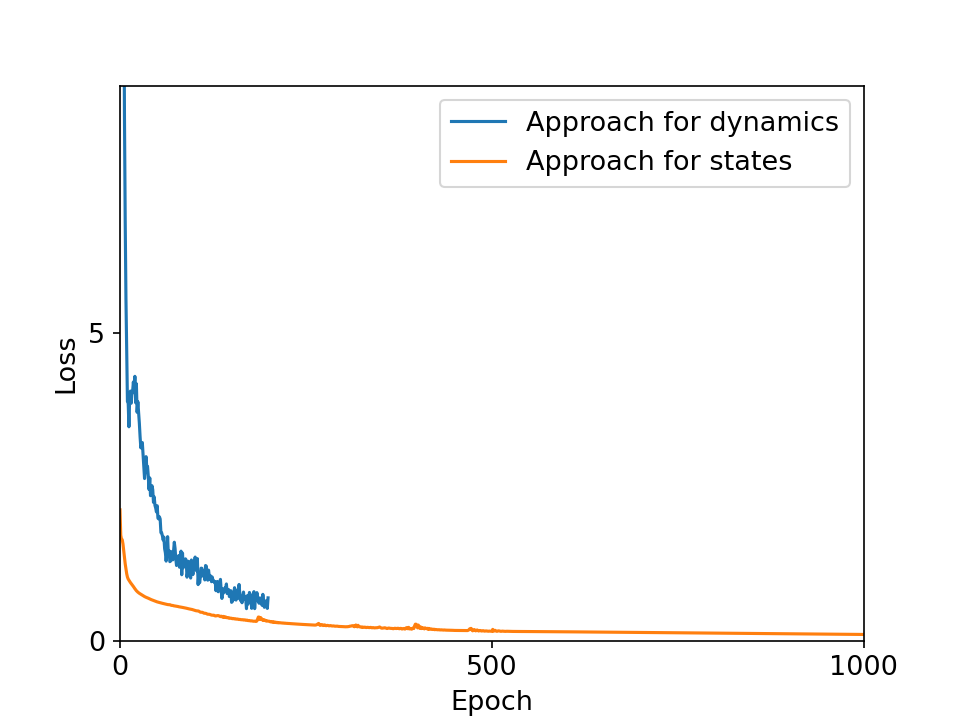

In [37]:
# 12. print loss part4
len(loss_rec2)
figloss=plt.figure(1613)

plt.plot(range(len(loss_rec)),loss_rec)
plt.plot(range(len(loss_rec2)),loss_rec2)
# plt.plot(range(1000),loss_rec[1:1001])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Epoch",fontsize=13)
plt.ylabel("Loss",fontsize=13)

ax=plt.gca()
ax.set_xticks([0, 500, 1000])# fig3ar f1a f4a f4c
ax.set_yticks([0,5,10])# fig3ar f1a f2e1 f4a f4c

plt.ylim(0,9) # fig3ar f1a f2e1 f4a f4c
plt.xlim(0,1000) #fig3ar f1a f4a f4c
plt.legend(['Approach for dynamics','Approach for states'],fontsize=13)
# savefig_path="./lastout/out-ori/ex1/losswhole"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)
# lossmat2=np.array(loss_rec2)
# io.savemat("./lastout/out-ori/ex1/loss_st.mat",{"loss2":lossmat2})

<IPython.core.display.Javascript object>


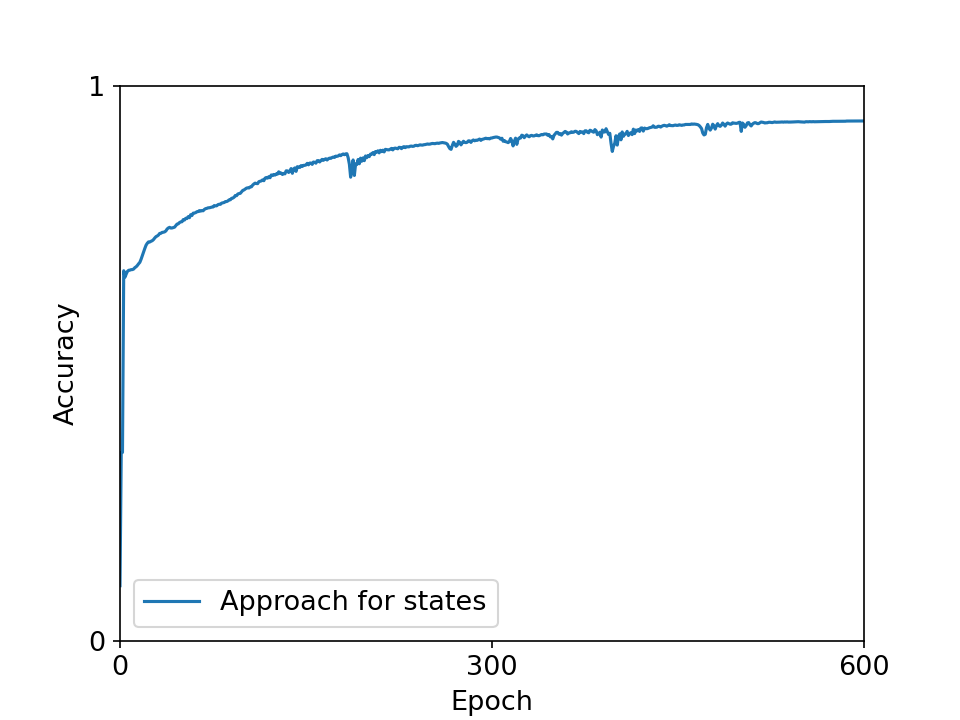

In [39]:
# 13. print accuracy
len(loss_rec2)
figloss=plt.figure(1614)

plt.plot(range(len(pre_rate2)),pre_rate2)
# plt.plot(range(1000),loss_rec[1:1001])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Epoch",fontsize=13)
plt.ylabel("Accuracy",fontsize=13)

ax=plt.gca()
ax.set_xticks([0, 300,600])# fig3ar f1a f4a f4c
ax.set_yticks([0,1])# fig3ar f1a f2e1 f4a f4c

plt.ylim(0,1) # fig3ar f1a f2e1 f4a f4c
plt.xlim(0,600) #fig3ar f1a f4a f4c
plt.legend(['Approach for states'],fontsize=13)
# savefig_path="./lastout/out-ori/ex1/lossaccwhole"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)

In [40]:
# 14. save model
torch.save(model,"./mod/your_model.pth")
torch.save(model2,"./mod/your_state_model.pth") 

In [4]:
# 15. loading model module
#载入已学好的模型 
model=torch.load('./mod/mod.pth').to(dev)
## special settings for model
delta1=1/segm
shwtyp=False
model2=torch.load("./mod/modelstate2.pth") 
# model=torch.load('./mod/re/modqig_seg2st1ss2verynice.pth')
# model=torch.load('./mod/re/modqig_seg1st0ss1canimproveandsee4and18and19nice.pth')
# print(model)

In [41]:
# 16. simulation parameter setting
simnu=60
seej=0
simj=0
seealltype=False
simtype=False
if seealltype:
    jra=simnu
else:
    jra=1
if simtype:
    kra=simnu
else:
    kra=1
delta2=0.05/segm

In [42]:
# 17. curve fitting module
#模拟曲线模块 
# 2a1:0
# 2a2:1e-3
simu_d=1e-3
my_raodong=0
dis_ne=0
for j in range(kra):
    if not simtype:
        j=simj
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    
    for i in range(simnu):
#         if i<5:
#             continue
#         i=2
        start=50*i
        x1[i,:]=locals()[name1][start]
    x1=x1.to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
    stopsig=0
    with torch.no_grad():
        for t in range(36000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                rd=torch.randn(simnu,dim)*(simu_d)
                rd=rd.to(dev)
                x1=x1+rd
#                 x1=x1+torch.randn(dim)*(3e-3)
                locals()["w1"+name][k,:,:]=x1.detach()
                k=k+1
                if t%1000==999:
                    print(t)
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            

2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


In [27]:
# 18. special curve fitting module1
#模拟曲线模块 with special start: curve fitting module with special start
my_raodong=0
dis_ne=0
simnu=15
simj=0
for j in range(1):
    j=2
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    spe_ind=[344,379,413,461,522,566,633,687,721,768,821,924,977,1031,1090]
    for i in range(15):
        x1[i,:]=locals()[name1][spe_ind[i]]
    x1=x1.to(dev)
    k=0
    name="xxa"+"s"+'%d' %simj
    locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
    stopsig=0
    with torch.no_grad():
        for t in range(36000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                rd=torch.randn(simnu,dim)*(3e-4)
                rd=rd.to(dev)
                x1=x1+rd
#                 x1=x1+torch.randn(dim)*(3e-3)
                locals()["w1"+name][k,:,:]=x1.detach()
                k=k+1
                if t%1000==999:
                    print(t)
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            

2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


In [6]:
# 19. special curve fitting module2
#模拟曲线模块,扰动 恒定扰动 :curve fitting module with constant inhibition
simnu=60
dis_ne=13
dis_coe=0.02
j=0
name1="data"+'%d' %j
x1=torch.zeros(simnu,dim)
for i in range(simnu):
    start=50*i
    x1[i,:]=locals()[name1][start]
x1=x1.to(dev)
k=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(40000,simnu,dim).to(dev)
stopsig=0
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
    for t in range(36000):
        x1=x1+(model(x1)-x1*del2-10*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe)*delta2 
        if t%segm==segm-1:
            rd=torch.randn(dim)*(6e-4)
            rd=rd.to(dev)
            x1=x1+rd
            locals()["w1"+name][k,:,:]=x1.detach()
            k=k+1
            if t%1000==999:
                print(t)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            
            
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


In [67]:
# 20. special curve fitting module3
#模拟曲线模块, 同轨一条线不同位置扰动 curve fitting module for one curve with constant inhibition staring in diffrent place
simnu=16
raodong_seg=500
raodong_start=2000
dis_ne=13
dis_coe=1
j=0
name1="data"+'%d' %j
x1=torch.zeros(simnu,dim)
for i in range(simnu):
    start=100
    x1[i,:]=locals()[name1][start]
x1=x1.to(dev)
k=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(40000,simnu,dim).to(dev)
stopsig=0
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
    for t in range(36000):
        x1=x1+(model(x1)-x1*del2)*delta2 
        if t%segm==segm-1:
            rd=torch.randn(dim)*(3e-4)
            rd=rd.to(dev)
            x1=x1+rd
        sep_i=math.floor(min(max((t/segm-raodong_start)/raodong_seg,-0.5),simnu-2))
        x1[sep_i+2:simnu,:]=x1[0,:].repeat(simnu-2-sep_i,1)
        x1[1:sep_i+2,:]=x1[1:sep_i+2,:]-delta2*10*(x1[1:sep_i+2,:]@dis_tr+dis_coe1)*dis_tr2
        if t%segm==segm-1:
            locals()["w1"+name][k,:,:]=x1.detach()
            k=k+1
            if t%1000==999:
                print(sep_i)
                print(t)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            
            
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


-1
2999
-1
5999
1
8999
3
11999
5
14999
7
17999
9
20999
11
23999
13
26999
14
29999
14
32999
14
35999


In [13]:
# 21. load trace module
# 载入轨迹模块 
# simnu=15
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
# for j in range(1):
#     for i in range(simnu):
# #         if i<15:
# #             continue
#         name="xxa"+"s"+'%d' %j
#         temptr=torch.load("./tr/tr6"+'%d' %i+".pth")
#         sizm,sizn=temptr.shape
#         locals()["w1"+name][0:sizm,i,:]=temptr

# simnu=15
# j=2
# simj=2
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./tr/cyc2/1/tr_see=1nice_simnu=15.pth").to(dev)

# simnu=60
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/1-trace/cycle1-tr_see=3nice_simnu=60.pth").to(dev)


# locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
# j=1
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/1-trace/tr_see=1nice_simnu=15.pth").to(dev)


# （winl=200 winr=11400）
# simnu=15
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/1-trace/tr_see=1nice_simnu=15.pth").to(dev)

simnu=60
j=0
simj=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.load("./lastout/2-trace/tr_see=567nice_simnu=60.pth").to(dev)

# simnu=60
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/3-trace/trbignoise_see=0_simnu=60.pth").to(dev)

# simnu=16
# j=0
# simj=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./lastout/8-ban13/trban13_see=3and5_simnu=16.pth").to(dev)

# j=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.load("./tr/rewrite/1/tr.pth").to(dev)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))

In [43]:
# 22. the preparation for plotting
#画图辅助函数

def my_plot3(tr,left,right,colorname="null",dim1=0,dim2=1,dim3=2):
    if colorname=="null":
        line,=ax.plot3D(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1),tr[left:right,dim3].squeeze(-1))
    else:
        line,=ax.plot3D(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1),tr[left:right,dim3].squeeze(-1),color=colorname)
    return line

def my_plot3_w_st(tr,left,right,state):
    statelas1=state[left];
    lasswi=0
    for k in range(right):
        if k<left:
            continue
        if state[k+1]!=statelas1:
            my_plot3(tr,lasswi,k+2,colorname[statelas1.clone().type(torch.int).item()-1])
            lasswi=k+1
            statelas1=state[k+1]
    my_plot3(tr,lasswi,k+2,colorname[statelas1.clone().type(torch.int).item()-1])

def my_sca3(tr,left,right,colorname="null"):
    if colorname=="null":
        line=ax.scatter(tr[left:right,0].squeeze(-1),tr[left:right,1].squeeze(-1),tr[left:right,2].squeeze(-1))
    else:
        line=ax.scatter(tr[left:right,0].squeeze(-1),tr[left:right,1].squeeze(-1),tr[left:right,2].squeeze(-1),color=colorname)
    return line



def my_plot(tr,left,right,colorname="null",dim1=0,dim2=1):
    if colorname=="null":
        line,=plt.plot(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1))
    else:
        line,=plt.plot(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1),color=colorname)
    return line

def my_plot_w_st(tr,left,right,state,dim1=0,dim2=1):
    statelas1=state[left];
    lasswi=0
    for k in range(right):
        if k<left:
            continue
        if state[k+1]!=statelas1:
            my_plot(tr,lasswi,k+2,colorname[statelas1.clone().type(torch.int).item()-1],dim1,dim2)
            lasswi=k+1
            statelas1=state[k+1]
    my_plot(tr,lasswi,k+2,colorname[statelas1.clone().type(torch.int).item()-1],dim1,dim2)

def my_sca(tr,left,right,colorname="null",dim1=0,dim2=1):
    if colorname=="null":
        line=plt.scatter(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1))
    else:
        line=plt.scatter(tr[left:right,dim1].squeeze(-1),tr[left:right,dim2].squeeze(-1),color=colorname)
    return line


def plot_data(PC=True,ne1=0,ne2=1):
    for j in range(jra):
        if not seealltype:
            j=seej
        if PC:
            names="data%dcp" %j
        else:
            names="datasol%d" %j
        line=my_plot(globals()[names],0,recn[j],"gray",ne1,ne2)
        if not seealltype:
            break
    return line

plotarray=[0,1,4,5,6,2,3]

<IPython.core.display.Javascript object>


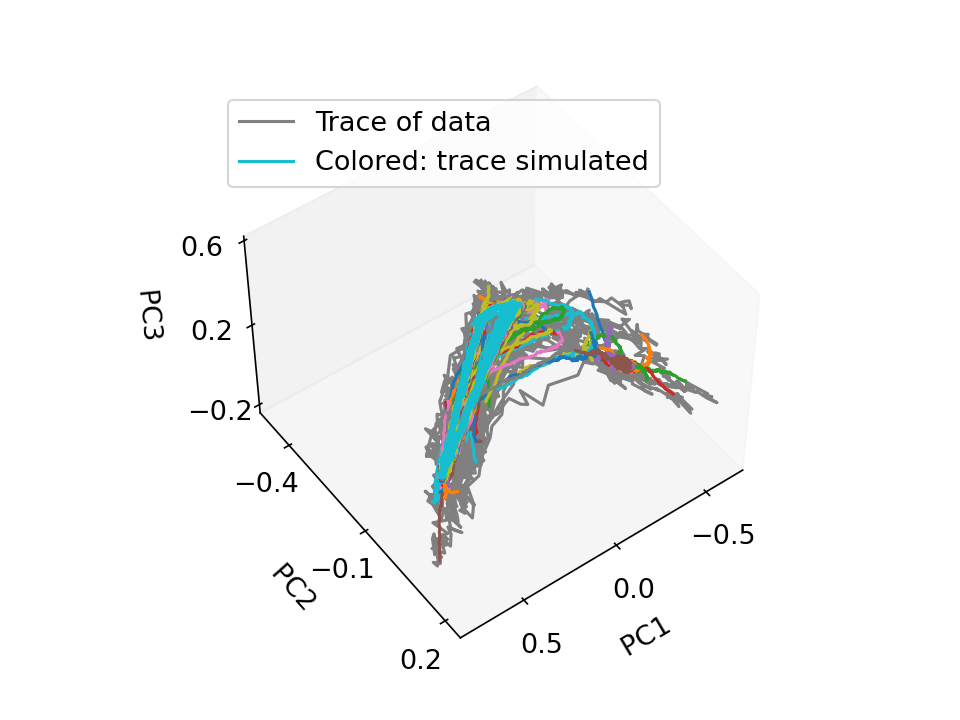

60


In [44]:
# 23. plot trace in 3D
#3维主成分画图


fig = plt.figure(4)
ax = plt.axes(projection='3d')
ax.view_init(48.863636363637,53.73376623376663)
# ax.view_init(90,-90)
for j in range(jra):
    if not seealltype:
        j=seej
    tempj=j+1
    names="state"+"%d" %tempj
    state=locals()[names]
    names="data%d" %j
    locals()[names+"cp"]=locals()[names].to(torch.device("cpu"))
    line1=my_plot3(locals()[names+"cp"],0,recn[j],"gray")
#     line1=my_plot3_w_st(locals()[names+"cp"],0,recn[j]-1,state)
    
see=-1
winl=0
winr=12000
print(simnu)
for j in range(kra): 
    if not simtype:
        j=simj
    for i in range(simnu):
        if see >= 0:
            i=see
        name="xxa"+"s"+'%d' %j 
        line2=my_plot3(locals()["w1"+name+"cp"][:,i,:],winl,winr)        
#         line2,=my_plot3(locals()["w1"+name+"cp"][:,i,:],winl,my_raodong-1,"null")
#         line2,=my_plot3(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,winr,"null")
#         line3=my_sca3(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,my_raodong,"red")
        if see >= 0:
            break;
plt.legend([line1,line2],["Trace of data","Colored: trace simulated"],loc="upper left",fontsize=13)
ax.grid(False)

ax.tick_params(labelsize=13)
ax.set_xlabel("\nPC1 ",fontsize=13) 
ax.set_ylabel("\nPC2 ",fontsize=13) 
ax.set_zlabel("\nPC3 ",fontsize=13) 
# ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(1))
# ax.zaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks([-0.5, 0, 0.5])
ax.set_yticks([-0.4, -0.1, 0.2])
ax.set_zticks([-0.2,0.2,0.6])
# savefig_path="./lastout/out-ori/2a1"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)

# plt.figure(5)

# plt.plot(kcou[0:1000],xxb2[0:1000])
# plt.plot(kcou[0:1000],xxb1[0:1000])¶

In [45]:
# 24. the prepare for plotting 2D
###### 2维多种展示准备
shwtyp=False    ## false兼容老式，true兼容新式

kcou=torch.zeros(500000,5)
kcou1=torch.zeros(500000,5)

tfie=12000

movet=torch.zeros(5,1);
move=0;

if not shwtyp:
    trant=10
    movet[0]=move/fps/10
else:
    trant=delta1/delta2
    for j in range(5):
        movet[j]=move/fpsarr[j]*(delta2/delta1)

        
winl=0
winr=12000
# 8:1,4
#7 see =1,3,4,
# 6:see=18
# 3:see=2 move=500/580
#4:see=3 move=?
# 5 :see=7/8 nomove

for j in range(5):
    kcou[:,j]=torch.tensor(range(500000))
    kcou1[:,j]=torch.tensor(range(500000))
    
if not shwtyp:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]/10
else:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]*(delta2/delta1)

for j in range(5):
    kcou1[:,j]=(kcou1[:,j]+move)/fpsarr[j] 

<IPython.core.display.Javascript object>


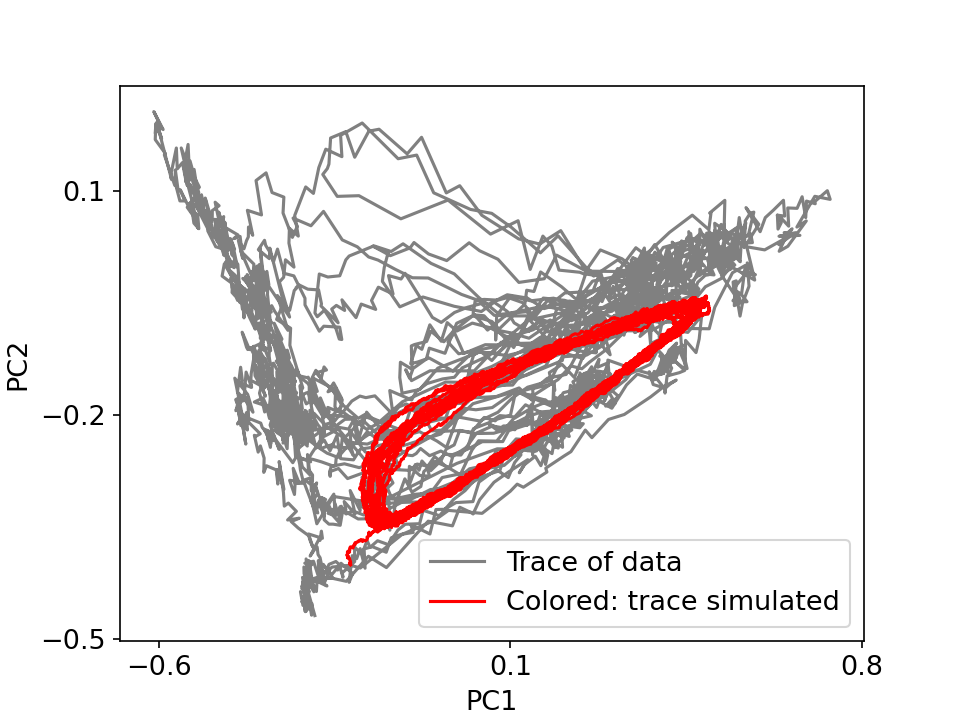

<IPython.core.display.Javascript object>


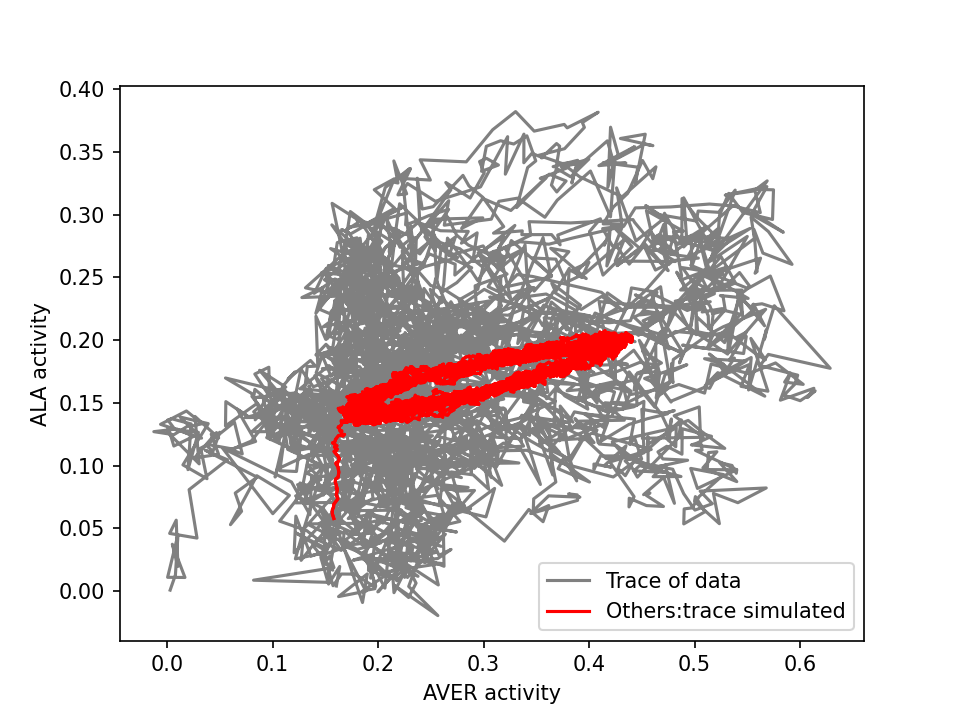

In [46]:
# 25. plot trace in 2D
# 2维画图
see=1
move=0
is_raodong=False;
ne1=7
ne2=2
# ne1=3# ne2=9# ne1=3# ne2=4# ne1=11# ne2=9# ne1=9# ne2=11# ne1=9# ne2=12# ne1=4# ne2=11# ne1=4# ne2=11# ne1=9# ne2=8# ne1=0# ne2=13
nes=4

winl=0 
winr=12000 #f8

for j in range(kra):
    plt.figure(5+100*j)
#    plt_sca=plt.scatter(locals()["w1"+name+"cp"][200,1,0],locals()["w1"+name+"cp"][200,1,1],s=100,color='green')    
#     plt_sca.set_zorder(11)
    if see!=-1 and see!=-3:
        line1=plot_data(True,0,1);
    plt.xlabel("PC1",fontsize=13)
    plt.ylabel("PC2",fontsize=13)
    if not simtype:
        j=simj
    for i in range(simnu):
        if see>=0:
            i=see
            name="xxa"+"s"+'%d' %j
            if is_raodong:
                line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,my_raodong-1,"green")
                line3=my_plot(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,winr,"red")
                line4=my_plot(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,my_raodong,"black")
                line4.set_zorder(2)
                plt.legend([line1,line2,line3,line4],["data","simulation before disabling","simulation after disabling","point of disabling"])
            else:
                line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,winr,"red",0,1)
                plt.legend([line1,line2],["trace of data","trace simulated"])
            break        
#         if i < 30:
#             continue
        if see==-1:
            plt.figure(50+i+100*j)
            line1=plot_data();
        plt.xlabel("PC1",fontsize=13)
        plt.ylabel("PC2",fontsize=13)
        name="xxa"+"s"+'%d' %j
        if is_raodong:
            line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,my_raodong-1,"green")
            line3=my_plot(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,winr,"red")
            line4=my_sca(locals()["w1"+name+"cp"][:,i,:],my_raodong-1,my_raodong,"black")
            line4.set_zorder(2)
            plt.legend([line1,line2,line3,line4],["data","simulation before disabling","simulation after disabling","point of disabling"])
        else:
            if see<-1:
                line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,winr)
            else:
                line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,winr,"red")
#             line2=my_plot(locals()["w1"+name+"cp"][:,i,:],winl,winr)
            #plt.legend([line1,line2],["trace of data","trace simulated"])
            #plt.legend([line1,line2],["trace of data","others:trace simulated"],fontsize=12)

#forpic8  
# if see==-2:
#     line2=my_plot(locals()["w1"+name+"cp"][:,0,:],winl,winr)
#     line2=my_plot(locals()["w1"+name+"cp"][:,0,:],winl,winr)
#     line2=my_plot(locals()["w1"+name+"cp"][:,0,:],winl,winr)
#     plt.legend([line1,line2],["trace of data","others:trace simulated"],fontsize=12)
#for pic8 pic2d
ax=plt.gca()
ax.set_xticks([-0.6, 0.1, 0.8])# f8c 2d
ax.set_yticks([-0.5, -0.2, 0.1])# f8c 2d

# next
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.title("each color means a trace we simulated\n and the point means the end of the trace")
plt.legend([line1,line2],["Trace of data","Colored: trace simulated"],fontsize=13)

# plt.savefig("./lastout/5/1.pdf",dpi=500)
# plt.savefig("./lastout/5/dis13coe0.1sim3.jpg",dpi=500)
# plt.savefig("./lastout/out3/8/d.pdf",dpi=500)
# plt.savefig("./lastout/out3/8/d.tif",dpi=500)
# plt.savefig("./lastout/out4/2e.pdf",dpi=500)
# plt.savefig("./lastout/out4/2e.tif",dpi=500)
# plt.savefig("./lastout/out-ori/8c.pdf",dpi=500)
# plt.savefig("./lastout/out-ori/8c.tif",dpi=500)
# plt.savefig("./lastout/out-ori/2d.pdf",dpi=500)
# plt.savefig("./lastout/out-ori/2d.tif",dpi=500)

for j in range(jra):
    if not seealltype:
        j=seej
    names="%d" %j
    locals()["datasol"+names]=locals()["data"+names+"cp"]@traa+cc0
for j in range(jra):
    plt.figure(6+100*j)
    if not seealltype:
        j=seej
    names="datasol%d" %j
    line1=plot_data(False,ne1,ne2)
    if not simtype:
        j=simj
    if see>=0:
        i=see
        name="xxa"+"s"+'%d' %j
        locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0
        line2,=plt.plot(locals()["wso"+name][winl:winr,i,ne1].squeeze(-1),locals()["wso"+name][winl:winr,i,ne2].squeeze(-1),"red")
        if is_raodong:
            line2=my_plot(locals()["wso"+name][:,i,:],winl,my_raodong-1,"green",ne1,ne2)
            line3=my_plot(locals()["wso"+name][:,i,:],my_raodong-1,winr,"red",ne1,ne2)
            line4=my_sca(locals()["wso"+name][:,i,:],my_raodong-1,my_raodong,"black",ne1,ne2)
            line4.set_zorder(2)
            plt.legend([line1,line2,line3,line4],["data","simulation before disabling","simulation after disabling","point of disabling"])
        else:
            line2=my_plot(locals()["wso"+name][:,i,:],winl,winr,"red",ne1,ne2)
            plt.legend([line1,line2],["trace of data","trace simulated"])
        plt.xlabel(nename[ne1]+" activity")
        plt.ylabel(nename[ne2]+" activity")        
# plt.legend([line1,line2],["trace of data","and others: trace simulated using the learned F"])
plt.legend([line1,line2],["Trace of data","Others:trace simulated"])
# # plt.savefig("./show1/23.png")




# plt.figure(7)
# for j in range(jra):
#     if not seealltype:
#         j=seej
#     names="datasol%d" %j
#     line1,=plt.plot(kcou1[0:round(tfie/trant),0],locals()[names][i*50:i*50+round(tfie/trant),nes],color="gray")
# for j in range(kra):
#     if not simtype:
#         j=simj
#     for i in range(1):
#         i=see
#         name="xxa"+"s"+'%d' %j
#         locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0
#         line2,=plt.plot(kcou[winl:winr,j],locals()["wso"+name][winl:winr,i,nes].squeeze(-1),"red")
# #         line3=plt.scatter(kcou[500,j],locals()["wso"+name][500,i,nes].squeeze(-1),color="black")
# #         line3.set_zorder(2)
# plt.xlabel("time(s)")
# plt.ylabel(nename[nes]+" activity")
# # plt.legend([line1,line2],["data","and others:simulated using the learned F"])
# plt.legend([line1,line2],["trace of data","trace simulated,moved \n through t axes "+'%.2f' %movet[0] + "s"])
# # plt.legend([line1,line2],["trace of data","t1race simulated"])

# plt.savefig("./lastout/out4/2e.pdf",dpi=500)
# plt.savefig("./lastout/out4/8/2e.tif",dpi=500)



#3,18

<IPython.core.display.Javascript object>


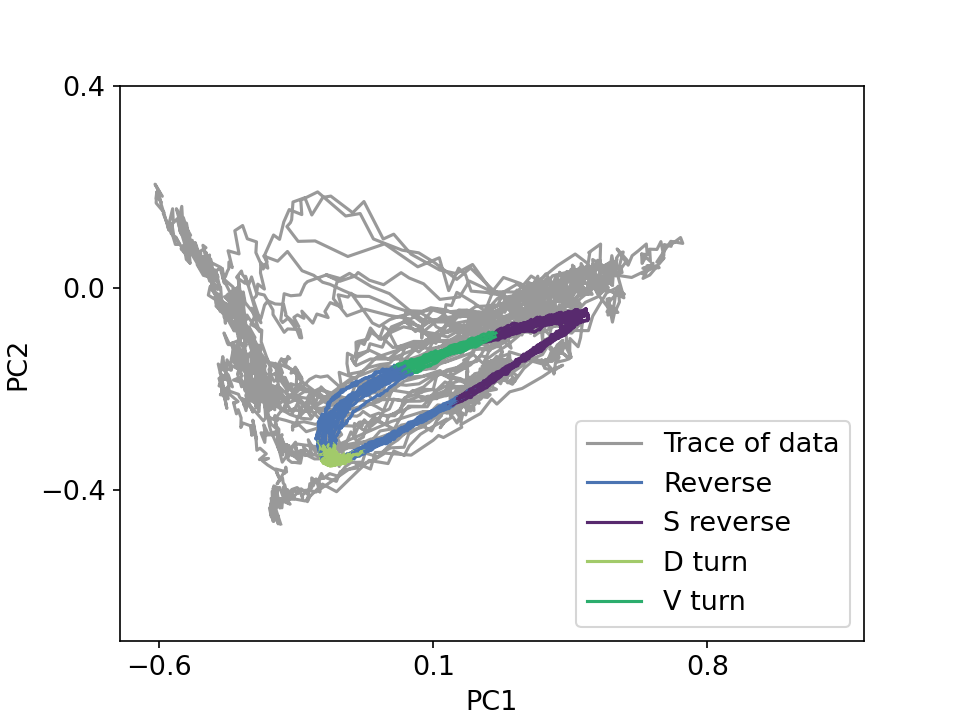

tensor(5, dtype=torch.int32)


<IPython.core.display.Javascript object>


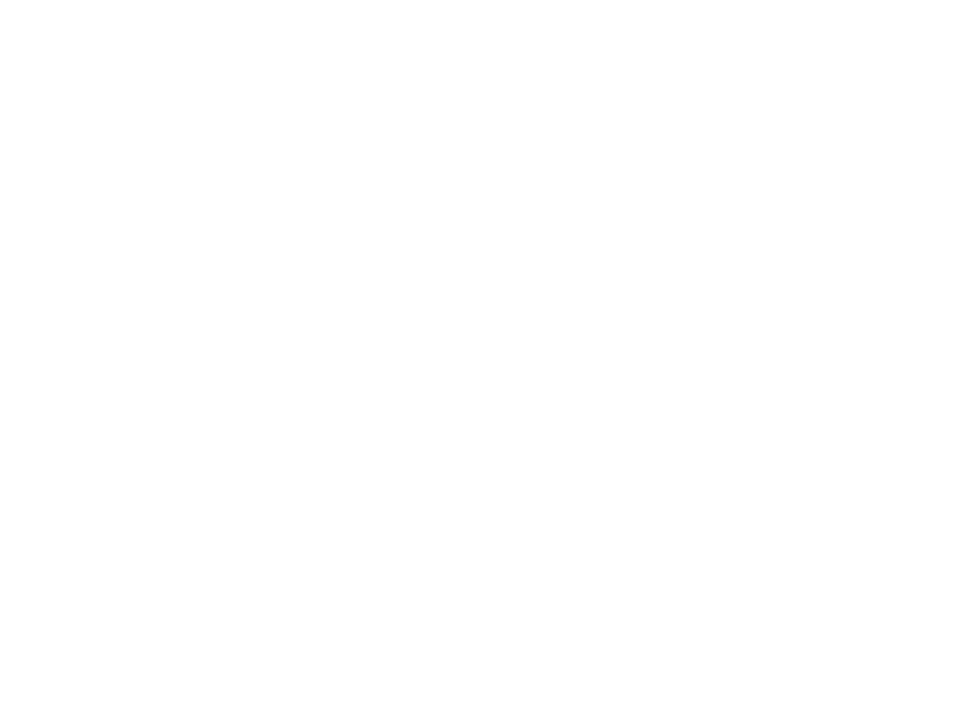

<IPython.core.display.Javascript object>


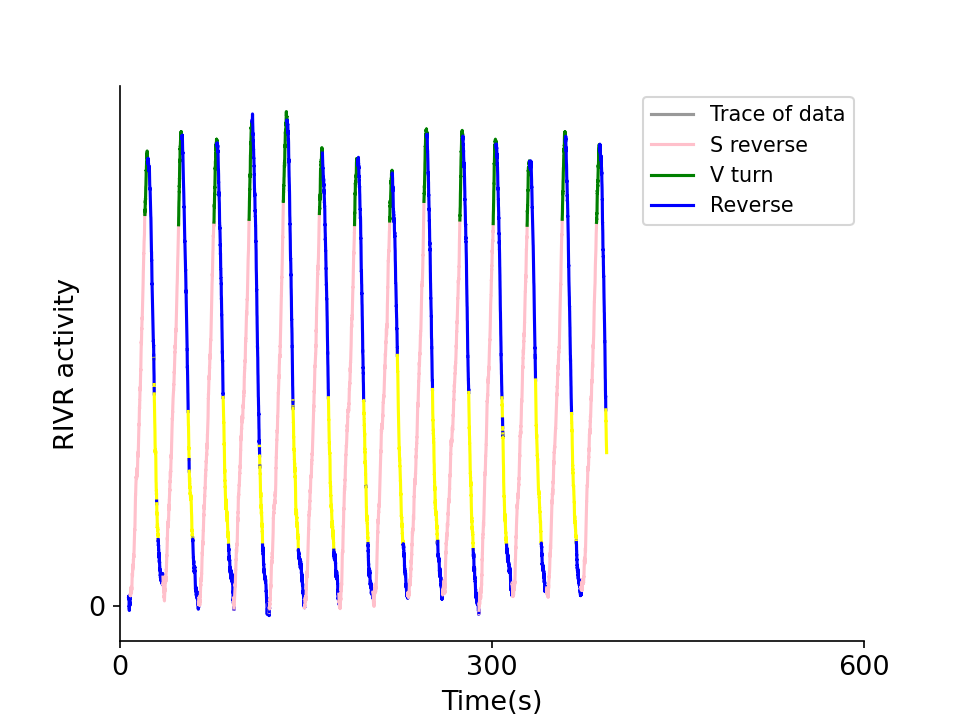

tensor([0.000000000000000e+00, 3.442779928445816e-02, 6.885559856891632e-02,
         ..., 1.721379492187500e+04, 1.721383007812500e+04,
        1.721386328125000e+04])
tensor([0.000000000000000e+00, 3.442779779434204e-01, 6.885559558868408e-01,
         ..., 1.721379531250000e+05, 1.721382968750000e+05,
        1.721386406250000e+05])
[5, 6, 3, 4, 2]


<IPython.core.display.Javascript object>


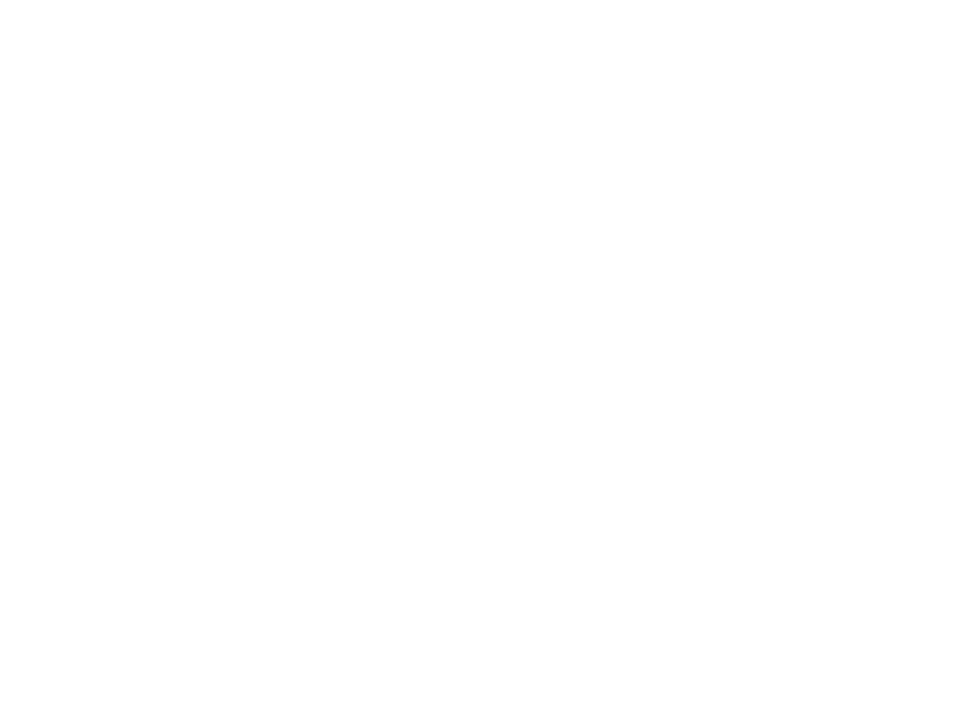

<IPython.core.display.Javascript object>


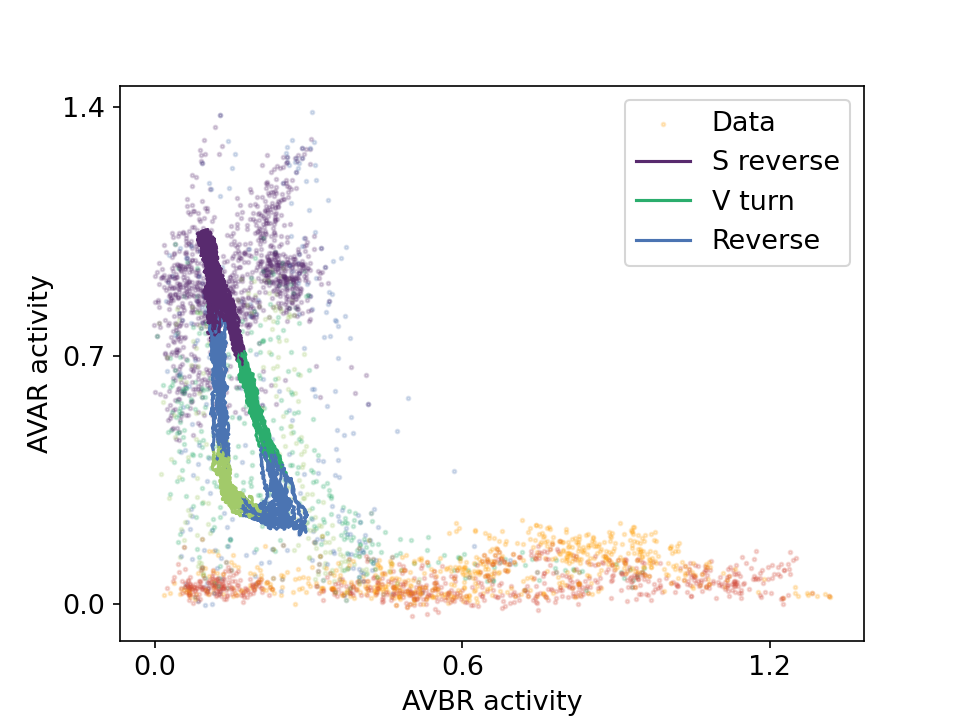

Text(0, 0.5, 'AVAR activity')

In [47]:
# 26. 2D color plot
#: color corresponding to behavior
#2维画图 颜色表示行为 
#3:see3 0,830,1200,2500,3300,4200,5100,6000  /3200,4300  p:120,900,3650

#3:see1 0,400,1200,2000,2700/3300,4000    p:1450,3300

#3:see2 640 ,2000,3400,4200,5300

def fenduan(tempx):
    for k in range(7):
        if cumleishu[k]<= tempx < cumleishu[k+1]:
            return k+1
    

# def learnst(dataofst,tf,use_type=1):
#     if use_type==1:
#         trst1=torch.zeros(tfie*10,1)
#         for i in range(round(tf/100)):
#             tempstgo=stgosorted.repeat(100,1,1)
#             tempda=dataofst[i*100:i*100+100,:]
#             tempda=tempda.repeat(cumleishu[7],1,1).transpose(0,1)
#             tempfd=torch.nn.PairwiseDistance(2)
#             tempdis=tempfd(tempstgo,tempda)
#             tempar=torch.argmin(tempdis,1)
#             tempar=tempar.to(torch.device("cpu"))
#             for k in range(100):
#                 trst1[k+i*100]=fenduan(tempar[k])  
#     else:
#         trst1=(model2(dataofst[:tf,:]).argmax(1)+1).type(torch.int)
#     return trst1 
def learnst(dataofst,tf,use_type=1):
    trst1=(model2(dataofst[:tf,:]).argmax(1)+1).type(torch.int)
    return trst1 
    
    
    
draw3a=False;    
sca_col=[]
tfie=12000
see=1
# winl=0
# winr=12000
winl=200
winr=11400
# winl=0
# winr=11500
# winl=1500
# winr=2500 #fig4c

# j=2
j=0;
name="xxa"+"s"+'%d' %j
locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0

plt.figure(8)

# for tt in range(100):
#     if stpoi[0,tt]==0:
#         break;
# plt.scatter(stpoi[0,0:tt].detach(),stpoi[1,0:tt].detach(),s=10,color="black")

if not draw3a:
    for j in range(jra):
        if not seealltype:
            j=seej
        names="data%d" %j
        linelk,=plt.plot(locals()[names+"cp"][0:recn[j],0:1],locals()[names+"cp"][0:recn[j],1:2],color="gray",alpha=0.8)

if draw3a:
    trst2=learnst(data0.to(dev),recn[j])
    sca_col=[]
    for j in range(jra):
        if not seealltype:
            j=seej
    #     tempj=j+1
    #     names="state%d" %tempj
        names="trst2"
        name2="data%d" %j
        statelas1=locals()[names][0];
        lasswi=0
        for k in range(recn[j]-1):
            if locals()[names][k+1]!=statelas1:
                labeler=statelas1.clone().type(torch.int).item()-1
                namer="linel"+'%d' %labeler
                locals()[namer]=plt.scatter(locals()[name2+"cp"][lasswi:k+2,0],locals()[name2+"cp"][lasswi:k+2,1],s=3,color=colorname2[statelas1.clone().type(torch.int).item()-1],alpha=0.2)
                if not labeler in sca_col:
                    sca_col.append(labeler)
                lasswi=k+1
                statelas1=locals()[names][k+1]
        labeler=statelas1.clone().type(torch.int).item()-1
        namer="linel"+'%d' %labeler
        locals()[namer]=plt.scatter(locals()[name2+"cp"][lasswi:k+2,0],locals()[name2+"cp"][lasswi:k+2,1],s=6,color=colorname2[statelas1.clone().type(torch.int).item()-1],alpha=0.2)
        if not labeler in sca_col:
            sca_col.append(labeler)


plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("PC1",fontsize=13)
plt.ylabel("PC2",fontsize=13)

ax=plt.gca()
ax.set_xticks([-0.6, 0.1, 0.8])# fig3ar f1a f4a f4c
ax.set_yticks([-0.4, 0, 0.4])# fig3ar f1a f2e1 f4a f4c

plt.ylim(-0.7,0.4) # fig3ar f1a f2e1 f4a f4c
plt.xlim(-0.7,1.2) #fig3ar f1a f4a f4c
# plt.xlim(-0.7,1.3) #f2e1

# plt.ylim(-0.6,0.3) # fig1a fig3a fig8e8f
# plt.xlim(-0.7,0.9) #fig2e1old
# plt.ylim(-0.7,0.3) #fig2e1old

j=simj
i=see
name="xxa"+"s"+'%d' %j
# line2,=plt.plot(locals()["w1"+name][0:tfie,0:1].squeeze(-1),locals()["w1"+name][0:tfie,1:2].squeeze(-1),"red")

trst1=learnst(locals()["w1"+name][:,i,:],winr,2)


for t in range(winr-winl):
    if trst1[winl+t]==4 and trst1[winl+t+1]==1:
        print(locals()["wso"+name][winl+t,i,13],winl+t)

#for cycle2
for t in range(winr-winl):
    if winl+t>700 and winl+t+1<11000 and trst1[winl+t]==4 and locals()["wso"+name][winl+t,i,13]<0.72:
        trst1[winl+t]=7

# #for 4a
# for t in range(winr-winl):
#     if winl+t>3200 and winl+t+1<11000 and trst1[winl+t]==4 and locals()["wso"+name][winl+t,i,13]<0.72:
#         trst1[winl+t]=7

        
#for cycle1   and f8
for t in range(winr-winl):
    if trst1[winl+t]==2 and locals()["wso"+name][winl+t,i,13]>1.251:
        trst1[winl+t]=1

if not draw3a:
    plot_col=[]
    statelas2=trst1[winl];
    print(statelas2-1)
    lasswi=winl
    for k in range(winr-1):
        if k<winl:
            continue
        if trst1[k+1]!=statelas2:
            labeler=statelas2.clone().type(torch.int).item()-1
            namer="linel"+'%d' %labeler
            locals()[namer],=plt.plot(locals()["w1"+name+"cp"][lasswi:k+2,i,0:1],locals()["w1"+name+"cp"][lasswi:k+2,i,1:2],color=colorname2[labeler])
            if not labeler in plot_col:
                plot_col.append(labeler)
            lasswi=k+1
            statelas2=trst1[k+1]    
    labeler=statelas2.clone().type(torch.int).item()-1
    namer="linel"+'%d' %labeler
    locals()[namer],=plt.plot(locals()["w1"+name+"cp"][lasswi:k+2,i,0:1],locals()["w1"+name+"cp"][lasswi:k+2,i,1:2],color=colorname2[labeler])
    if not labeler in plot_col:
        plot_col.append(labeler)
if draw3a:
    j=0
    i=3
    name="xxa"+"s"+'%d' %j
    line_cycle1,=plt.plot(locals()["w1"+name+"cp"][0:12000,i,0:1],locals()["w1"+name+"cp"][0:12000,i,1:2],color=(0.4,0.5,0.6),linewidth =3.0)
    j=1
    i=1
    name="xxa"+"s"+'%d' %j
    line_cycle2,=plt.plot(locals()["w1"+name+"cp"][200:11400,i,0:1],locals()["w1"+name+"cp"][200:11400,i,1:2],color="cyan",linewidth =3.0)
# linel2,=plt.plot([0,0],[0,0],color=colorname[2])
# line1,=plt.plot(data0[0:3000,0:1],data0[0:3000,1:2],"gray")


# plt.legend([line1,line2],["trace of data","and others: trace simulated using the learned F"])
# plt.legend([line1,line2],["trace of data","trace simulated using the learned F"])
# plt.legend([linelk,line2],["trace of data","trace simulated"])

if not draw3a:
    tempar1=[linelk]
    tempar2=["Trace of data"]##
else:
    tempar1=[]
    tempar2=[]
Reverse_down=False
if draw3a:
    true_plotarray=range(7)
else:
    true_plotarray=plotarray

for i in plotarray:
# for i in [6,3,4]:
# for i in [1,0,4,6,3,2]:
# for i in [1,4,6,3,0]:
    name="linel%d" %i
    if i in plot_col and not draw3a:
        if i==4:
            Reverse_down=True
        if i==5 and Reverse_down:
            continue
        tempar1.append(locals()[name])
        tempar2.append(staten[i])
    if i in sca_col and draw3a:
        if i==4:
            Reverse_down=True
        if i==5 and Reverse_down:
            continue
        tempar1.append(locals()[name])
        tempar2.append(staten[i])

if draw3a:
    tempar1.append(line_cycle1)
    tempar2.append("Cycle 1")
    tempar1.append(line_cycle2)
    tempar2.append("Cycle 2")
plt.legend(tempar1,tempar2,fontsize=13)

# plt.legend([line1,line2],["line: data","point:attractor points"])

winlt=winl/10/fps
winrt=winr/10/fps

# plt.title("trace simulated,t between  "+'%.2f' %winlt + "s"+" and " +'%.2f' %winrt + " s")

# savefig_path="./lastout/out-isc/3ar"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)




# winl=0
# winr=500 # figloss32


nes=13

plt.figure(9)
fig, ax_time=plt.subplots()
ax_time.spines['right'].set_visible(False)
ax_time.spines['top'].set_visible(False)
j=simj
i=see

move=0              ##560
movet=torch.zeros(5,1);
if not shwtyp:
    trant=10
    movet[0]=move/fps/10
else:
    trant=delta1/delta2
    for j in range(5):
        movet[j]=move/fpsarr[j]*(delta2/delta1)
for j in range(5):
    kcou[:,j]=torch.tensor(range(500000))
    kcou1[:,j]=torch.tensor(range(500000))
if not shwtyp:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]/10
else:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]*(delta2/delta1)

for j in range(5):
    kcou1[:,j]=(kcou1[:,j]+move)/fpsarr[j] 
    

for j in range(jra):
    if not seealltype:
        j=seej
    names="%d" %j
    locals()["datasol"+names]=locals()["data"+names+"cp"]@traa+cc0

print(kcou[:,0])

print(kcou1[:,0])

# for j in range(jra):
#     if not seealltype:
#         j=seej
#     names="datasol%d" %j
#     linelk,=plt.plot(kcou1[0:round(tfie/trant),j],locals()[names][i*50:i*50+round(tfie/trant),nes],color="gray",alpha=0.5)


# print(locals()[names][i*50,nes])

# linelk,=plt.plot(kcou1[0:round(tfie/10),0],datasol0[i*50:i*50+round(tfie/10),nes],color="gray",alpha=0.5)

# statelas1=state1[i*50];
# lasswi=0
# for k in range(round(tfie/10)):
#     if state1[i*50+k+1]!=statelas1:
#         plt.plot(kcou1[lasswi:k+2,0:1],datasol0[lasswi+i*50:i*50+k+2,nes],color=colorname[statelas1.clone().type(torch.int).item()-1],alpha=0.4)
#         lasswi=k+1
#         statelas1=state1[i*50+k+1]


plot_col=[]    
j=simj
statelas2=trst1[winl];
lasswi=winl
name="xxa"+"s"+'%d' %j
locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0
#old
# plt.ylim(0,2.2) #fig1c1
# plt.ylim(0.3,2) #fig1c2
# plt.xlim(0,500) # fig2e2
# plt.xlim(0,470) # fig4a,fig4c
# plt.xlim(0,420)#fig1c


#new
# plt.xlim(0,500) #fig1d
# plt.ylim(0,2.5)  #fig1d
# ax_time.set_xticks([0, 200, 400])#f1d
# ax_time.set_yticks([0, 1.0, 2.0])#f1d

# plt.xlim(0,400) #fig1e
# plt.ylim(0.3,2.1)  #fig1e
# ax_time.set_xticks([0, 200, 400])#f1e
# ax_time.set_yticks([0.4, 1.2, 2.0])#f1e
# winl=0 #f1e

# plt.xlim(0,550) # fig2e2
# ax_time.set_xticks([0, 200, 400])#f2e2
# ax_time.set_yticks([0, 1.0, 2.0])#f2e2

# plt.xlim(0,500) # fig4a2
# plt.ylim(-0.1,2.2) # fig4a2
# ax_time.set_xticks([0, 200, 400])#f4a2
# ax_time.set_yticks([0, 1.0, 2.0])#f4a2

# plt.xlim(0,50) # figloss3
# plt.ylim(-0.1,2.5) # figloss3
# ax_time.set_xticks([0, 25, 50])#floss3
# ax_time.set_yticks([0, 1.0, 2.0])#floss3


# plt.xlim(0,200) # figloss32
# plt.ylim(-0.1,2.5) # figloss32
# ax_time.set_xticks([0, 100, 200])#floss32
# ax_time.set_yticks([0, 1.0, 2.0])#floss32

plt.xlim(0,600) #figexex
ax_time.set_xticks([0, 300, 600])#figexex
ax_time.set_yticks([0, 1.0, 2.0])#figexex

for k in range(winr-1):
    if trst1[k+1]!=statelas2:
        if k<winl:
            continue
        labeler=statelas2.clone().type(torch.int).item()-1
        namer="linel"+'%d' %labeler
        locals()[namer],=plt.plot(kcou[lasswi:k+2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])
        if not labeler in plot_col:
            plot_col.append(labeler)
        lasswi=k+1
        statelas2=trst1[k+1]   
labeler=statelas2.clone().type(torch.int).item()-1
namer="linel"+'%d' %labeler
locals()[namer],=plt.plot(kcou[lasswi:k+2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])   

# winl2=2000
# winr2=6100
# windel2=440-800

# winl2=2300
# winr2=6100
# windel2=440-800
# lasswi=winl2
# for k in range(winr2-1):
#     if trst1[k+1]!=statelas2:
#         if k<winl2:
#             continue
#         labeler=statelas2.clone().type(torch.int).item()-1
#         namer="linel"+'%d' %labeler
#         locals()[namer],=plt.plot(kcou[lasswi:k+2,j]+kcou[winr,j]-kcou[winl2+windel2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])
#         if not labeler in plot_col:
#             plot_col.append(labeler)
#         lasswi=k+1
#         statelas2=trst1[k+1]   
# labeler=statelas2.clone().type(torch.int).item()-1
# namer="linel"+'%d' %labeler
# locals()[namer],=plt.plot(kcou[lasswi:k+2,j]+kcou[winr,j]-kcou[winl2+windel2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])   

if not labeler in plot_col:
    plot_col.append(labeler)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Time(s)",fontsize=13)
plt.ylabel(nename[nes]+" activity",fontsize=13)
tempar1=[linelk]
tempar2=["Trace of data"]
print(plot_col)
# tempar1=[]
# tempar2=[]
Reverse_down=False
# for i in plotarray:
# for i in [6,3,4]:
# for i in [1,0,4,6,3,2]:
# for i in [1,4,6,3,0]:
for i in [6,3,4,0]:
# for i in [0,1,5,6,3]:
    name="linel%d" %i
    if i in plot_col:
        if i==4:
            Reverse_down=True
        if i==5 and Reverse_down:
            continue
        tempar1.append(locals()[name])
        tempar2.append(staten[i])
plt.legend(tempar1,tempar2,fontsize=10)
# plt.legend([line1,line2],["transparent means data","solid means simulated"])


    
# plt.title("trace simulated,moved \n through t axes "+'%.2f' %movet + "s")
# plt.savefig("./pic/show5/5.png",dpi=500)

# savefig_path="./lastout/out-ori/ex1/l44a"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)

# ,loc="upper right"







# pic5a 6 4
#pic5d 13 4
#pic6a 0 12
#pic6b 0 13
#pic7a 3 11
#pic7b 6 8
#pic7c 7 11
#pic7d 1 10
ne1=6
ne2=4
# ne3=13

plt.figure(1010)
fig, ax=plt.subplots()

ax.set_xticks([0, 0.6, 1.2])#f5a
ax.set_yticks([0, 0.7, 1.4])#f5a

# ax.set_xticks([0, 1, 2])#f5c
# ax.set_yticks([0, 0.7, 1.4])#f5c


# ax.set_xticks([0, 0.6, 1.2])#f6a
# ax.set_yticks([0, 0.6, 1.2])#f6a
# winl=500 #f6a
# plt.xlim(-0.27,1.3)  #f6a

# ax.set_xticks([0, 0.6, 1.2])#f6b
# ax.set_yticks([0, 1, 2])#f6b
# winl=500 #f6b
# plt.xlim(-0.27,1.3)  #f6b

# ax.set_xticks([0, 0.6, 1.2])#f7a
# ax.set_yticks([0, 1.1, 2.2])#f7a
# winl=500 #f7a
# plt.ylim(-0.15,2.5)  #f7a

# ax.set_xticks([0, 0.6, 1.2])#f7b
# ax.set_yticks([0, 0.25, 0.5])#f7b
# winl=500 #f7b


# ax.set_xticks([0, 0.3, 0.6])#f7c
# ax.set_yticks([0, 1.1, 2.2])#f7c
# winl=500 #f7c

# ax.set_xticks([0, 0.4, 0.8])#f7d
# ax.set_yticks([0, 0.8, 1.6])#f7d
# winl=500 #f7d




# plt.plot(datasol0[0:tfie,ne1],datasol0[0:tfie,ne2],"gray")
trst2=learnst(data0.to(dev),recn[j])

for j in range(jra):
    if not seealltype:
        j=seej
#     tempj=j+1
#     names="state%d" %tempj
    names="trst2"
    name2="datasol%d" %j
    statelas1=locals()[names][0];
    lasswi=0
    for k in range(recn[j]-1):
        if locals()[names][k+1]!=statelas1:
            plt.scatter(locals()[name2][lasswi:k+2,ne1],locals()[name2][lasswi:k+2,ne2],s=3,color=colorname2[statelas1.clone().type(torch.int).item()-1],alpha=0.2)
            lasswi=k+1
            statelas1=locals()[names][k+1]
    linelk=plt.scatter(locals()[name2][lasswi:k+2,ne1],locals()[name2][lasswi:k+2,ne2],s=3,color=colorname2[statelas1.clone().type(torch.int).item()-1],alpha=0.2)


# j=2        
i=see
name="xxa"+"s"+'%d' %j
locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0


plot_col=[]
statelas2=trst1[winl];
lasswi=winl
for k in range(winr-1):
    if trst1[k+1]!=statelas2:    
        if k<winl:
            continue
        labeler=statelas2.clone().type(torch.int).item()-1
        namer="linel"+'%d' %labeler
        locals()[namer],=plt.plot(locals()["wso"+name][lasswi:k+2,i,ne1],locals()["wso"+name][lasswi:k+2,i,ne2],color=colorname2[labeler])
        if not labeler in plot_col:
            plot_col.append(labeler)
        lasswi=k+1
        statelas2=trst1[k+1]   
labeler=statelas2.clone().type(torch.int).item()-1
namer="linel"+'%d' %labeler
locals()[namer],=plt.plot(locals()["wso"+name][lasswi:k+2,i,ne1],locals()["wso"+name][lasswi:k+2,i,ne2],color=colorname2[labeler])
if not labeler in plot_col:
    plot_col.append(labeler)

# plpo1=plt.scatter(locals()["wso"+name][winl,ne1],locals()["wso"+name][winl,ne2],color="black")
# plpo2=plt.scatter(locals()["wso"+name][winr-1,ne1],locals()["wso"+name][winr-1,ne2],color="purple")

# plpo1.set_zorder(2)
# plpo2.set_zorder(2)

# plt.legend([linel0,linel1,linel2,linel3,linel4,linel6,plpo1,plpo2],["Forward","Slow","D turn","V turn","Reverse","S reverse","Trace start","Trace end"],loc="upper left")

tempar1=[linelk]
tempar2=["Data"]
Reverse_down=False
# for i in plotarray:
for i in [6,3,4]:    
    name="linel%d" %i
    if i in plot_col:
        if i==4:
            Reverse_down=True
        if i==5 and Reverse_down:
            continue
        tempar1.append(locals()[name])
        tempar2.append(staten[i])
plt.legend(tempar1,tempar2,fontsize=13)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel(nename[ne1]+" activity",fontsize=13)
plt.ylabel(nename[ne2]+" activity",fontsize=13)
# plt.xlim(-0.195,1.3)#pic6
# plt.xlim(-0.199,0.95)#pic7d

# savefig_path="./lastout/out-isc/5a2"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)





# plt.savefig("./pic/show5/19.png",dpi=500)

## 6 4,8 5,12 8, 13 4

In [11]:
# 27. esti Diffusion coefficient
seg=3
ss=2

my_loss_fn = torch.nn.MSELoss(reduction='sum')
i=tr_num_learn
name="data"+'%d' %i
with torch.no_grad():
    xpre=locals()[name][0:reclen[i]-ss-2].to(dev)
    for j in range(segm):
        xpre=xpre+(model(xpre)-xpre*del2)*delta1/2
    temp1=locals()[name][1:reclen[i]-ss-2+1]
    my_temp_D = 2*my_loss_fn(temp1,xpre.to(torch.device("cpu")))*(fpsarr[i]/2)/dim/(reclen[i]-ss-3)

print(my_temp_D)
        
my_D=my_temp_D.to(dev)
print(my_D/segm/delta1)


tensor(0.000413509842474)
tensor(0.000413509842474)


In [23]:
# 28. the attraction and sigma 



tfield=4000
simnu=150
simnu1=30
x1=torch.zeros(simnu,dim)
for j in range(5):
    name1="data"+'%d' %j
    name1="data"+'%d' %j
    for i in range(simnu1):
        start=100*i
        x1[i+j*simnu1,:]=locals()[name1][start]

temp5=torch.zeros(simnu)
x1=x1.to(dev)
sigmae=torch.zeros(simnu,dim,dim).to(dev)
my_I=torch.eye(dim).to(dev)
my_A=torch.zeros(simnu,dim,dim).to(dev)
k=0
j=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(50000,simnu,dim)
locals()["simsigma"+name]=torch.zeros(50000,simnu,dim,dim)
for temp3 in range(simnu):
    sigmae[temp3]=my_I*my_D
for t in range(tfield*segm):
    if(t%1200==1200-1):
        print("simulation done:", (t+1)/(tfield*segm)*100, "%")
    x1.requires_grad=True
    for j in range(dim):
        y1=model(x1)-del2*x1
        if j>0:
            x1.grad.zero_()
        y1jsum=torch.sum(y1[:,j])
        y1jsum.backward()
        my_A[:,j,:]=x1.grad
    with torch.no_grad():
        sigmae=sigmae+(sigmae@my_A+torch.transpose(my_A,1,2)@sigmae+2*my_D/segm/delta1*my_I)*delta2
        x1=x1+(model(x1)-x1*del2)*delta2
#         rd=torch.randn(simnu,dim)*(3e-4)
#         rd=rd.to(dev)
#         x1=x1+rd
        if t%segm==segm-1:
            locals()["w1"+name][k,:,:]=x1.detach()
            locals()["simsigma"+name][k,:,:,:]=sigmae.detach()
            if k%500 == 499: 
                for j in range(simnu):
                    if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-400,j,:])>1e-2:
                        temp5[j]=0
                    if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-400,j,:])<1e-2 and temp5[j]<1 and t<32000:
                        print(k,j,locals()["w1"+name][k,j,:])
                        temp5[j]=2
            k=k+1
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))

stopk=0

for j in range(simnu):
    if temp5[j]>1:
        stopk=stopk+1
print(stopk)


simulation done: 10.0 %
499 6 tensor([-0.587345123291016,  0.187762558460236,  0.082178443670273,
         0.434639871120453, -0.251421272754669, -0.090734928846359,
         0.015469778329134, -0.002352526411414,  0.041045501828194,
        -0.035254720598459,  0.028579726815224, -0.026484670117497,
         0.015791155397892, -0.004807429388165])
499 8 tensor([ 9.030851721763611e-02, -9.016439318656921e-02,  3.931937217712402e-01,
        -6.270266324281693e-02,  1.180296540260315e-01, -7.433763891458511e-02,
        -7.641167193651199e-02,  7.926515489816666e-02, -1.913003474473953e-01,
         8.166774362325668e-02,  8.649780601263046e-02,  3.056316450238228e-02,
        -2.815097197890282e-02,  6.335472426144406e-05])
499 15 tensor([-0.321475088596344, -0.208535298705101,  0.014836538583040,
         0.217721626162529,  0.079619221389294, -0.073222190141678,
         0.045668959617615, -0.027231231331825, -0.041799675673246,
         0.021996302530169, -0.023650120943785, -0.0094

simulation done: 30.0 %
1499 5 tensor([ 0.439528763294220,  0.003147094976157,  0.107348263263702,
         0.058020025491714,  0.050100937485695,  0.153847008943558,
        -0.122145339846611,  0.014599430374801, -0.051915571093559,
         0.014735402539372,  0.040644574910402, -0.018616039305925,
        -0.045162715017796, -0.013393711298704])
1499 20 tensor([-0.466202139854431,  0.044597521424294,  0.044526562094688,
         0.451278775930405, -0.072525456547737, -0.176378354430199,
        -0.042189240455627, -0.121252775192261,  0.033741854131222,
        -0.001385297393426,  0.005399088375270, -0.009335396811366,
         0.033699754625559, -0.000505823991261])
1499 37 tensor([ 0.439528763294220,  0.003147074254230,  0.107348248362541,
         0.058020025491714,  0.050100944936275,  0.153847038745880,
        -0.122145324945450,  0.014599426649511, -0.051915578544140,
         0.014735409989953,  0.040644578635693, -0.018616044893861,
        -0.045162715017796, -0.01339370

simulation done: 40.0 %
simulation done: 50.0 %
1999 31 tensor([ 0.439528763294220,  0.003147088456899,  0.107348248362541,
         0.058020032942295,  0.050100944936275,  0.153847008943558,
        -0.122145339846611,  0.014599432237446, -0.051915571093559,
         0.014735401608050,  0.040644578635693, -0.018616043031216,
        -0.045162711292505, -0.013393715023994])
1999 82 tensor([ 0.439528733491898,  0.003147088456899,  0.107348278164864,
         0.058020025491714,  0.050100959837437,  0.153847008943558,
        -0.122145339846611,  0.014599432237446, -0.051915571093559,
         0.014735404402018,  0.040644578635693, -0.018616039305925,
        -0.045162715017796, -0.013393713161349])
1999 90 tensor([-0.466202080249786,  0.044597510248423,  0.044526562094688,
         0.451278805732727, -0.072525449097157, -0.176378339529037,
        -0.042189240455627, -0.121252797544003,  0.033741854131222,
        -0.001385297975503,  0.005399083252996, -0.009335402399302,
         0.033

In [24]:
# 29. save variable for attractors
j=0
name="xxa"+"s"+'%d' %j
j=0
name1="xxb"+"s"+'%d' %j
import scipy.io as io
for i in range(simnu):
    if temp5[i]>1:
        print(torch.norm(locals()["simsigma"+name][tfield-1,i,:,:]-locals()["simsigma"+name][tfield-100,i,:,:]))
        if torch.norm(locals()["simsigma"+name][tfield-1,i,:,:]-locals()["simsigma"+name][tfield-100,i,:,:])>1e-3:
            temp5[i]=0
            stopk=stopk-1
print(stopk)
    
savesigma=torch.zeros(stopk,dim,dim)
savepoi=torch.zeros(stopk,dim)
k=0
win_le=0
for i in range(simnu):
    if temp5[i]>1:
        savesigma[k,:,:]=locals()["simsigma"+name][tfield-1,i,:,:]
        savepoi[k,:]=locals()["w1"+name][tfield-1,i,:]
        k=k+1

savesigma=np.array(savesigma)
io.savemat("./output/attractor/sig.mat",{"simsigma":savesigma})            
savepoi=np.array(savepoi)
io.savemat("./output/attractor/poi.mat",{"simpoi":savepoi})


tensor(2.273736754432321e-13)
tensor(1.136868377216160e-13)
tensor(4.652834107582438e-13)
tensor(3.584343858165084e-06)
tensor(0.)
tensor(0.)
tensor(1.607774650176294e-13)
tensor(7.105427357601002e-15)
tensor(9.094947017729282e-13)
tensor(0.)
tensor(0.)
tensor(3.215549300352588e-13)
tensor(2.273736754432321e-13)
tensor(2.273736754432321e-13)
tensor(5.796914055548885e-13)
tensor(0.)
tensor(4.652834107582438e-13)
tensor(0.)
tensor(8.038873250881470e-14)
tensor(0.)
tensor(1.154867000641158e-12)
tensor(0.)
tensor(1.278976924368180e-13)
tensor(0.)
tensor(1.321685951872001e-13)
tensor(0.)
tensor(0.699676871299744)
tensor(5.684341886080801e-14)
tensor(0.622069060802460)
tensor(5.907341131018706e-13)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(8.038873250881470e-14)
tensor(2.273736754432321e-13)
tensor(2.542115010249063e-13)
tensor(1.797546757709850e-13)
tensor(0.)
tensor(8.297240932514383e-13)
tensor(8.038873250881470e-14)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.045150186014532e-12)


In [13]:
# 30. the attraction and sigma with inhibition

#dis_coe=5
dis_coe=5
tfield=4000
dis_ne=13
simnu1=30
simnu=5*simnu1
x1=torch.zeros(simnu,dim)
for j in range(5):
    jplus1=j+1
    name1="data"+'%d' %j
    for i in range(simnu1):
        start=100*i
        x1[i+j*simnu1,:]=locals()[name1][start]
temp5=torch.zeros(simnu)
x1=x1.to(dev)
sigmae=torch.zeros(simnu,dim,dim).to(dev)
my_I=torch.eye(dim).to(dev)
my_A=torch.zeros(simnu,dim,dim).to(dev)
k=0
j=0
stopk=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(50000,simnu,dim)
locals()["simsigma"+name]=torch.zeros(50000,simnu,dim,dim)
for temp3 in range(simnu):
    sigmae[temp3]=my_I*my_D
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
for t in range(tfield*segm):
    if(t%1200==1200-1):
        print("simulation done:", (t+1)/(tfield*segm)*100, "%")
    x1.requires_grad=True
    for j in range(dim):
        y1=model(x1)-del2*x1-2*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe
        if j>0:
            x1.grad.zero_()
        y1jsum=torch.sum(y1[:,j])
        y1jsum.backward()
        my_A[:,j,:]=x1.grad
    with torch.no_grad():
        sigmae=sigmae+(sigmae@my_A+torch.transpose(my_A,1,2)@sigmae+2*my_D/segm/delta1*my_I)*delta2
        x1=x1+(model(x1)-x1*del2)*delta2-delta2*2*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe
#         rd=torch.randn(simnu,dim)*(3e-4)
#         rd=rd.to(dev)
#         x1=x1+rd
        if t%segm==segm-1:
            locals()["w1"+name][k,:,:]=x1.detach()
            locals()["simsigma"+name][k,:,:,:]=sigmae.detach()
            if k%500 == 499: 
                for j in range(simnu):
                    if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-400,j,:])>1e-2 and temp5[j]>1:
                        temp5[j]=0
                        stopk=stopk-1
                    if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-400,j,:])<1e-2 and temp5[j]<1 and t<32000:
                        print(k,j,locals()["w1"+name][k,j,:])
                        temp5[j]=2
                        stopk=stopk+1
                print(t,stopk)
            k=k+1
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))

stopk=0

for j in range(simnu):
    if temp5[j]>1:
        stopk=stopk+1
print(stopk)            
            
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1



simulation done: 10.0 %
499 2 tensor([-0.328964889049530, -0.173297405242920, -0.001574218040332,
         0.234325185418129,  0.006916743237525, -0.069378271698952,
         0.050737462937832, -0.004751163069159, -0.024389451369643,
         0.012986420653760, -0.033887710422277, -0.031267937272787,
        -0.003903689328581,  0.001980566419661])
499 12 tensor([ 0.494681328535080,  0.009357343427837, -0.010398535057902,
         0.102397456765175, -0.056805904954672,  0.073931112885475,
        -0.090295277535915,  0.023367609828711, -0.063160337507725,
         0.044871043413877, -0.086229898035526, -0.132763057947159,
        -0.052953876554966, -0.058779403567314])
499 13 tensor([-0.328917682170868, -0.173356726765633, -0.001596476184204,
         0.234270215034485,  0.007093050517142, -0.069395594298840,
         0.050731793045998, -0.004774697124958, -0.024431256577373,
         0.013013254851103, -0.033920913934708, -0.031241521239281,
        -0.003878960618749,  0.00198259111

simulation done: 20.0 %
999 0 tensor([-0.328974068164825, -0.173288211226463, -0.001571111381054,
         0.234333917498589,  0.006891142111272, -0.069375529885292,
         0.050738669931889, -0.004748008679599, -0.024383191019297,
         0.012982508167624, -0.033882666379213, -0.031271845102310,
        -0.003907105419785,  0.001980316126719])
999 1 tensor([-0.328970909118652, -0.173289448022842, -0.001571097876877,
         0.234332531690598,  0.006892112083733, -0.069375887513161,
         0.050738114863634, -0.004747824277729, -0.024383641779423,
         0.012982656247914, -0.033883124589920, -0.031271658837795,
        -0.003907171543688,  0.001980261644349])
999 4 tensor([ 0.369207918643951, -0.020343171432614, -0.102341972291470,
         0.188007563352585,  0.064380511641502,  0.125182643532753,
        -0.075696393847466, -0.095115035772324, -0.019584665074944,
         0.049736298620701, -0.060330051928759, -0.094954423606396,
         0.006915562320501, -0.0683580487966

simulation done: 30.0 %
1499 3 tensor([ 0.619808375835419,  0.072847187519073, -0.159925431013107,
         0.110075831413269,  0.082215853035450,  0.105572000145912,
        -0.210174933075905,  0.073306426405907, -0.146791025996208,
         0.038268409669399, -0.051861699670553, -0.031161542981863,
        -0.057221848517656, -0.002800649264827])
1499 42 tensor([ 0.619808375835419,  0.072847187519073, -0.159925431013107,
         0.110075831413269,  0.082215853035450,  0.105572007596493,
        -0.210174933075905,  0.073306426405907, -0.146791025996208,
         0.038268409669399, -0.051861699670553, -0.031161541119218,
        -0.057221848517656, -0.002800648799166])
1499 53 tensor([ 0.619808375835419,  0.072847187519073, -0.159925431013107,
         0.110075831413269,  0.082215853035450,  0.105572007596493,
        -0.210174933075905,  0.073306426405907, -0.146791025996208,
         0.038268409669399, -0.051861699670553, -0.031161537393928,
        -0.057221848517656, -0.00280064

In [ ]:
# 31. the attraction and simulation traces with inhibition
tfield2=12000
simnu=150
simnu1=30
x1=torch.zeros(simnu,dim)
for j in range(5):
    jplus1=j+1
    name1="data"+'%d' %j
    for i in range(simnu1):
        start=100*i
        x1[i+j*simnu1,:]=locals()[name1][start]
j=0
x1=x1.to(dev)
k=0
name="xxb"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(40000,simnu,dim).to(dev)
stopsig=0
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
    for t in range(tfield2*segm):
        x1=x1+(model(x1)-x1*del2)*delta2-delta2*10*(x1@dis_tr+dis_coe1)*dis_tr2
        if t%segm==segm-1:
            rd=torch.randn(dim)*(4e-3)
            rd=rd.to(dev)
            x1=x1+rd
        if t%segm==segm-1:
            locals()["w1"+name][k,:,:]=x1.detach()
            k=k+1
            if t%1000==999:
                print(t)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
print(name)

In [16]:
## 32. save variables of attractors with inhibition
j=0
name="xxa"+"s"+'%d' %j
j=0
name1="xxb"+"s"+'%d' %j
import scipy.io as io
for i in range(simnu):
    if temp5[i]>1:
        print(torch.norm(locals()["simsigma"+name][tfield-1,i,:,:]-locals()["simsigma"+name][tfield-100,i,:,:]))
        if torch.norm(locals()["simsigma"+name][tfield-1,i,:,:]-locals()["simsigma"+name][tfield-100,i,:,:])>1e-4:
            temp5[i]=0
            stopk=stopk-1
print(stopk)
    
savesigma=torch.zeros(stopk,dim,dim)
savepoi=torch.zeros(stopk,dim)
# savetr=torch.zeros(tfield2*stopk,dim)
k=0
win_le=0
for i in range(simnu):
    if temp5[i]<1:
        print(i,"!")
    if temp5[i]>1:
        savesigma[k,:,:]=locals()["simsigma"+name][tfield-1,i,:,:]
        savepoi[k,:]=locals()["w1"+name][tfield-1,i,:]
        is_save_tr=1
#         for j in range(k):
#             if torch.dist(locals()["w1"+name][tfield-1,i,:],locals()["w1"+name][tfield-1,j,:])<1e-4:
#                 is_save_tr=0
#                 break
# comment
#         if i%5==4 and is_save_tr==1:
#             for t in range(tfield2):
#                 if t%100==99:
#                     if torch.dist(locals()["w1"+name1][t,j,:],locals()["w1"+name1][t+100,j,:])<1e-3:
#                         break
#             savetr[win_le:win_le+t,:]=locals()["w1"+name1][0:t,i,:]
#             win_le=win_le+t;
#             print(i)
        k=k+1

# savetr=savetr[0:win_le,:]
savesigma=np.array(savesigma)
io.savemat("./output/attractor/dis"+'%d' %dis_ne+"/coe"+'%f' %dis_coe+"sig.mat",{"simsigma":savesigma})            
savepoi=np.array(savepoi)
io.savemat("./output/attractor/dis"+'%d' %dis_ne+"/coe"+'%f' %dis_coe+"poi.mat",{"simpoi":savepoi})
# savetr=np.array(savetr)
# io.savemat("./attrpo/dis/"+'%d' %dis_ne+"/score.mat",{"score":savetr})

tensor(6.821210263296962e-13)
tensor(0.)
tensor(5.084230020498126e-13)
tensor(1.917807411358843e-13)
tensor(2.340955337562511e-12)
tensor(0.)
tensor(7.236381632802491e-13)
tensor(4.019436625440735e-14)
tensor(4.338013455396084e-12)
tensor(4.484509985580587e-12)
tensor(4.582862951976741e-13)
tensor(1.245376956941768e-12)
tensor(0.)
tensor(0.)
tensor(2.690321706730336e-12)
tensor(4.344324899818730e-11)
tensor(3.708352635384271e-12)
tensor(5.684341886080801e-14)
tensor(8.507544170012482e-13)
tensor(2.273736754432321e-13)
tensor(9.094947017729282e-13)
tensor(7.628992381401856e-13)
tensor(5.684341886080801e-14)
tensor(4.810747069802779e-13)
tensor(4.359282574674384e-13)
tensor(6.168493233565941e-12)
tensor(0.)
tensor(1.591615728102624e-12)
tensor(0.)
tensor(2.273736754432321e-13)
tensor(4.547473508864641e-13)
tensor(2.273736754432321e-13)
tensor(0.)
tensor(0.)
tensor(4.067384016398501e-12)
tensor(6.437376131283867e-13)
tensor(0.)
tensor(1.245376956941768e-12)
tensor(6.996591348819303e-13)
t

In [13]:
## 33. save moment information of limit cycle
j=0
name="xxa"+"s"+'%d' %j 
see=5
ncycle=1
if ncycle==1:
    string_ncycle=""
else:
    string_ncycle='%d' %ncycle
tem_x=torch.zeros(dim)
parFij=torch.zeros(12000,dim,dim)
Fi=torch.zeros(12000,dim)
cycle=torch.zeros(12000,dim)
for i in range(12000):
    tem_x=locals()["w1"+name+"cp"][i,see,:].to(dev)
    tem_x.requires_grad=True
    cycle[i,:]=tem_x
    for j in range(dim):
        if j>0:
            tem_x.grad.zero_()
        tem_y=model(tem_x)-del2*tem_x
        Fi[i,:]=tem_y
        y1jsum=torch.sum(tem_y[j])
        y1jsum.backward()
        parFij[i,j,:]=tem_x.grad
    if i%1000==0:
        print(i)
save_parFij=np.array(parFij.detach().to(torch.device("cpu")))
io.savemat("./output/parFij"+string_ncycle+".mat",{"parFij"+string_ncycle:save_parFij})
save_Fi=np.array(Fi.detach().to(torch.device("cpu")))
io.savemat("./output/Fi"+string_ncycle+".mat",{"Fi"+string_ncycle:save_Fi})
save_cycle=np.array(cycle.detach().to(torch.device("cpu")))
io.savemat("./output/cy"+'%d' %ncycle+".mat",{"cy"+'%d' %ncycle:save_cycle})

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [12]:
## 34. save moment information of limit cycle after inhibition
j=0
name="xxa"+"s"+'%d' %j 
see=5
ncycle=1
dis_coe=0.02
dis_ne=13
if ncycle==1:
    string_ncycle=""
else:
    string_ncycle='%d' %ncycle
tem_x=torch.zeros(dim)
parFij=torch.zeros(12000,dim,dim)
Fi=torch.zeros(12000,dim)
cycle=torch.zeros(12000,dim)
with torch.no_grad():
    dis_e=torch.zeros(dim,1)
    dis_e[dis_ne]=1
    dis_coe1=cc0@dis_e
    dis_coe1=dis_coe1.item()
    dis_tr=traa@dis_e
    dis_tr2=dis_e.T@trab
    dis_e=dis_e.to(dev)
    dis_tr=dis_tr.to(dev)
    dis_tr2=dis_tr2.to(dev)
    dis_coe2=dis_tr.T@dis_tr
    dis_coe2=dis_coe2.item()
for i in range(12000):
    tem_x=locals()["w1"+name+"cp"][i,see,:].to(dev)
    tem_x.requires_grad=True
    cycle[i,:]=tem_x
    for j in range(dim):
        if j>0:
            tem_x.grad.zero_()
        tem_y= model(tem_x)-del2*tem_x-2*(tem_x@dis_tr+dis_coe1)*dis_tr2*dis_coe
        Fi[i,:]=tem_y
        y1jsum=torch.sum(tem_y[0][j])
        y1jsum.backward()
        parFij[i,j,:]=tem_x.grad
    if i%1000==0:
        print(i)
save_parFij=np.array(parFij.detach().to(torch.device("cpu")))
io.savemat("./output/attractor/dis"+'%d' %dis_ne+"/coe"+'%f' %dis_coe+"parFij"+string_ncycle+".mat",{"parFij"+string_ncycle:save_parFij})
save_Fi=np.array(Fi.detach().to(torch.device("cpu")))
io.savemat("./output/attractor/dis"+'%d' %dis_ne+"/coe"+'%f' %dis_coe+"Fi"+string_ncycle+".mat",{"Fi"+string_ncycle:save_Fi})
save_cycle=np.array(cycle.detach().to(torch.device("cpu")))
io.savemat("./output/attractor/dis"+'%d' %dis_ne+"/coe"+'%f' %dis_coe+"cy"+'%d' %ncycle+".mat",{"cy"+'%d' %ncycle:save_cycle})

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [8]:
# cycle2_start=w1xxas0[200,1,:]
# print(cycle2_start)

In [9]:
# dataFile = '.\\data\\surface_B.mat'
# mat1 = io.loadmat(dataFile)
# surface_B=mat1['surface_B']
# xsidel=-0.8;xsider=0.9;ysidel=-0.6;ysider=0.4;step=0.005;
# xx=xsidel
# part_x=torch.ones(3)
# x1=torch.zeros(340,200,dim)
# for k in range(340):
#     yy=ysidel
#     for l in range(200):
#         part_x[1]=xx
#         part_x[2]=yy
#         x1[k,l,0]=xx
#         x1[k,l,1]=yy
#         x1[k,l,2:14]=(part_x@surface_B).T
#         yy=yy+step
#     xx=xx+step
# x1=x1.to(dev)
# Fx=model(x1)-x1*del2


In [10]:
# savex1=np.array(x1.detach().to(torch.device("cpu")))
# io.savemat("./lastout/5/x1.mat",{"x1":savex1}) 
# savefx=np.array(Fx.detach().to(torch.device("cpu")))
# io.savemat("./lastout/5/fx.mat",{"fx":savefx}) 

<IPython.core.display.Javascript object>


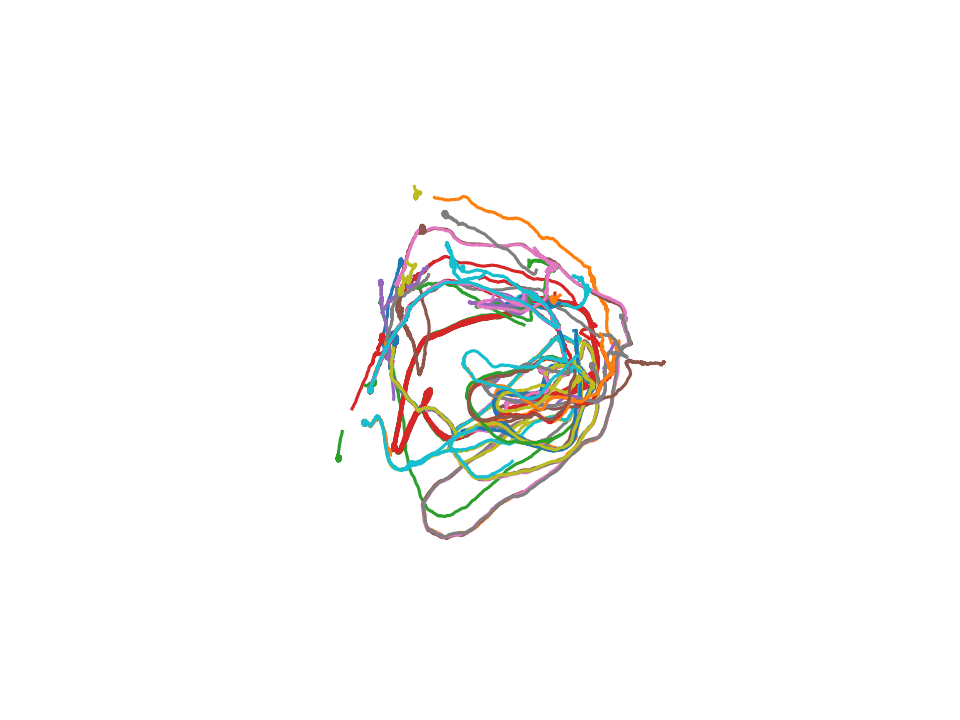

(-0.6588483870029449,
 0.7744766294956207,
 -0.45183214247226716,
 0.22414275705814363)

In [15]:
#2维画图
# plot trace in 2D

winl=0 
winr=12000 #f8
plt.figure(1987)
ax = plt.axes(projection='3d')
ax.view_init(-127,-90)
for j in range(kra):

    if not simtype:
        j=simj
    for i in range(60):
        name="xxa"+"s"+'%d' %j
        line2=my_plot3(locals()["w1"+name+"cp"][:,i,:],winl,winr)   

#for pic8 pic2d
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.get_zaxis().set_visible(False)
plt.axis('off')

# plt.savefig("./lastout/is/a3.pdf",dpi=500)
# plt.savefig("./lastout/is/a3.tif",dpi=500)


torch.Size([40000, 16, 14])

In [66]:
# j=0
# name="xxa"+"s"+'%d' %j
# savecycle=np.array(locals()["w1"+name][0:12000,3,:])
# io.savemat("./lastout/out3/dis13/cycle2coe0.2.mat",{"cycle2":savecycle})            

In [62]:
#模拟曲线模块,扰动 恒定扰动
# # 0.02 0.04 0.08 0.1 0.2 0.3
# simnu=4
# dis_ne=13
# dis_coe=0.2
# j=0
# name1="data"+'%d' %j
# x1=torch.zeros(simnu,dim)
# # x1[2,:]=locals()[name1][100]
# x1[0,:]=torch.tensor([ 0.383432328701019, -0.008770209737122,  0.278092473745346,
#         -0.007047316525131,  0.064723089337349,  0.128932848572731,
#         -0.127335116267204,  0.010444960556924, -0.037215020507574,
#          0.046392936259508,  0.061080697923899, -0.007886825129390,
#         -0.037233985960484, -0.009063987992704])
# x1[1,:]=torch.tensor([ 0.288135141134262, -0.180263921618462,  0.017334828153253,
#          0.047641739249229, -0.026285089552402,  0.323385268449783,
#         -0.141068905591965, -0.054988633841276, -0.042012408375740,
#         -0.039858110249043, -0.032674267888069,  0.054257974028587,
#          0.015232254751027,  0.091671794652939])
# x1[2,:]=torch.tensor([-0.237985864281654, -0.186475738883018,  0.245175063610077,
#          0.042261317372322, -0.040564838796854, -0.061944551765919,
#          0.028784090653062,  0.036500189453363, -0.077814325690269,
#          0.021959986537695,  0.106747731566429,  0.039640273898840,
#          0.034177582710981,  0.002072973409668])
# x1[3,:]=torch.tensor([ 0.243470922112465, -0.069240204989910,  0.313836425542831,
#         -0.014558319933712, -0.009469780139625,  0.254133909940720,
#         -0.146125972270966, -0.046156998723745, -0.151451423764229,
#         -0.037389539182186,  0.017728855833411,  0.048510517925024,
#         -0.019225675612688,  0.020837994292378])
# x1=x1.to(dev)
# k=0
# name="xxa"+"s"+'%d' %j
# locals()["w1"+name]=torch.zeros(40000,simnu,dim).to(dev)
# stopsig=0
# with torch.no_grad():
#     dis_e=torch.zeros(dim,1)
#     dis_e[dis_ne]=1
#     dis_coe1=cc0@dis_e
#     dis_coe1=dis_coe1.item()
#     dis_tr=traa@dis_e
#     dis_tr2=dis_e.T@trab
#     dis_e=dis_e.to(dev)
#     dis_tr=dis_tr.to(dev)
#     dis_tr2=dis_tr2.to(dev)
#     dis_coe2=dis_tr.T@dis_tr
#     dis_coe2=dis_coe2.item()
#     for t in range(36000):
#         x1=x1+(model(x1)-x1*del2-2*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe)*delta2 
#         if t%segm==segm-1:
#             rd=torch.randn(dim)*(6e-4)
#             rd=rd.to(dev)
#             x1=x1+rd
#             locals()["w1"+name][k,:,:]=x1.detach()
#             k=k+1
#             if t%1000==999:
#                 print(t)
# locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            
            
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


3


In [157]:
# print(cycle2_start)
# j=0
# name1="data"+'%d' %j
# print(locals()[name1][150])
# print(start2)
# print(start3)

tensor([ 0.383432328701019, -0.008770209737122,  0.278092473745346,
        -0.007047316525131,  0.064723089337349,  0.128932848572731,
        -0.127335116267204,  0.010444960556924, -0.037215020507574,
         0.046392936259508,  0.061080697923899, -0.007886825129390,
        -0.037233985960484, -0.009063987992704])
tensor([ 0.288135141134262, -0.180263921618462,  0.017334828153253,
         0.047641739249229, -0.026285089552402,  0.323385268449783,
        -0.141068905591965, -0.054988633841276, -0.042012408375740,
        -0.039858110249043, -0.032674267888069,  0.054257974028587,
         0.015232254751027,  0.091671794652939])
tensor([-0.237985864281654, -0.186475738883018,  0.245175063610077,
         0.042261317372322, -0.040564838796854, -0.061944551765919,
         0.028784090653062,  0.036500189453363, -0.077814325690269,
         0.021959986537695,  0.106747731566429,  0.039640273898840,
         0.034177582710981,  0.002072973409668])
tensor([ 0.243470922112465, -0.069240

In [94]:
# j=0
# name="xxa"+"s"+'%d' %j
# savetr=np.array(locals()["w1"+name+"cp"][0:12000,2,:])
# io.savemat("./raod/old1/tra13.mat",{"tra":savetr})     

False

<IPython.core.display.Javascript object>


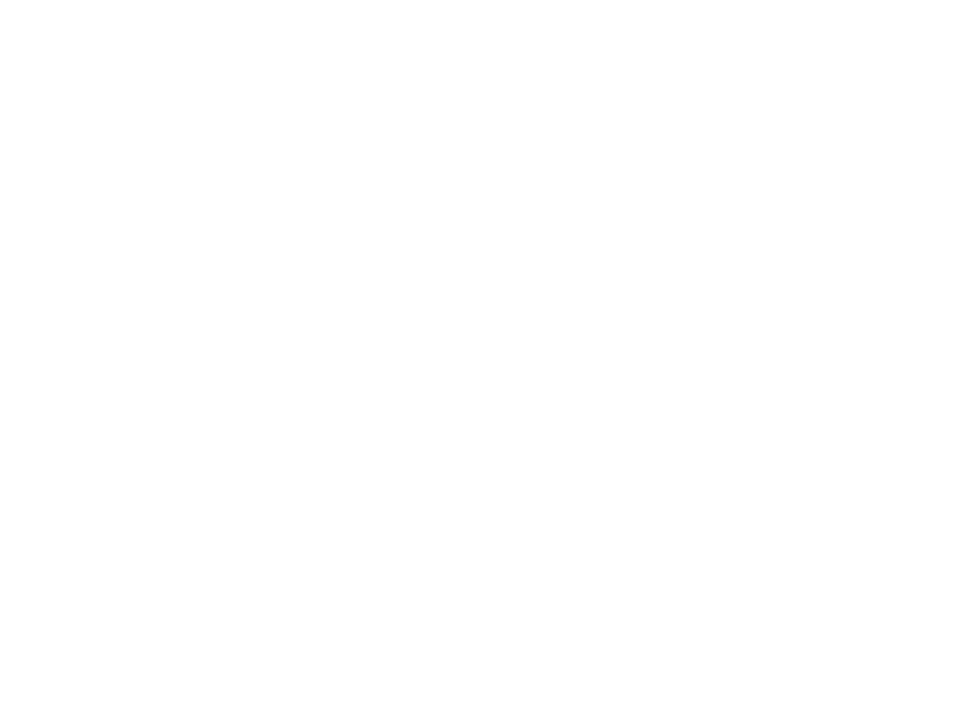

<IPython.core.display.Javascript object>


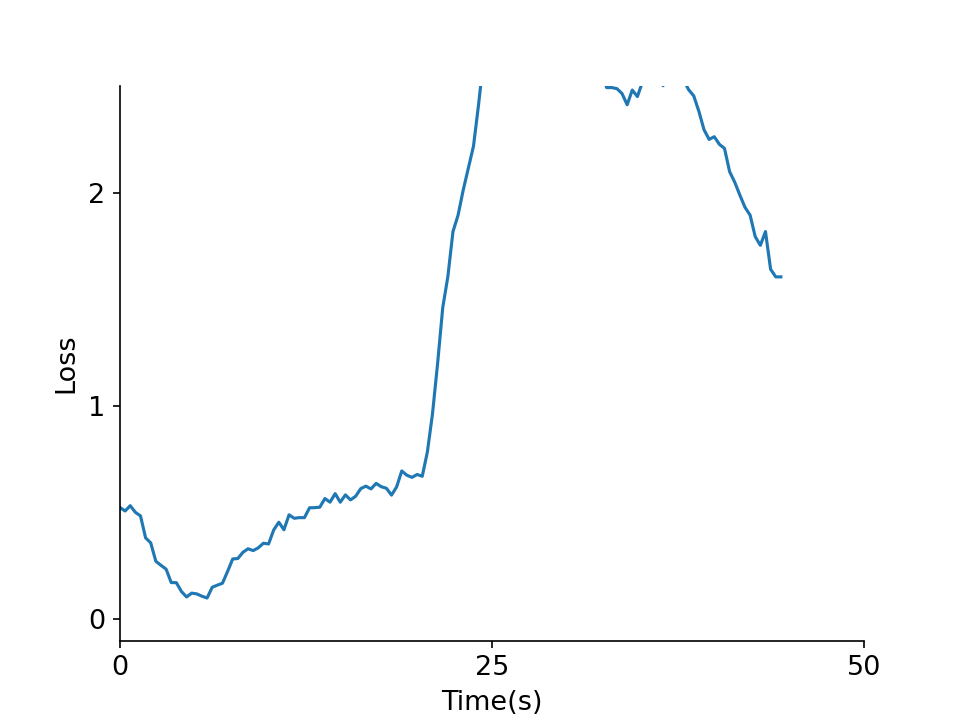

[]


In [25]:
winl=0
winr=200


nes=13

plt.figure(29)
fig, ax_time=plt.subplots()
ax_time.spines['right'].set_visible(False)
ax_time.spines['top'].set_visible(False)
j=simj
i=see

move=0              ##560
movet=torch.zeros(5,1);
if not shwtyp:
    trant=10
    movet[0]=move/fps/10

for j in range(5):
    kcou[:,j]=torch.tensor(range(500000))
    kcou1[:,j]=torch.tensor(range(500000))
if not shwtyp:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]/10

for j in range(5):
    kcou1[:,j]=(kcou1[:,j]+move)/fpsarr[j] 
    

for j in range(jra):
    if not seealltype:
        j=seej
    names="%d" %j
    locals()["datasol"+names]=locals()["data"+names+"cp"]@traa+cc0

plot_col=[]    
j=simj
statelas2=trst1[winl];
lasswi=winl
name="xxa"+"s"+'%d' %j
locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0

plt.xlim(0,50) # figloss3
plt.ylim(-0.1,2.5) # figloss3
ax_time.set_xticks([0, 25, 50])#floss3
ax_time.set_yticks([0, 1.0, 2.0])#floss3

# segleft=round(winl/10)
# segright=round(winr/10)
# print(locals()["wso"+name][segleft*10:10:segright*10,i,:])
# plt.plot(kcou1[segleft:segright,j],torch.norm(locals()["wso"+name][segleft*10:10:segright*10,i,:]-locals()["datasol"+names][i*50+segleft:i*50+segright,:],p=2,dim=1))   

winl2=400
winr2=1700
segleft2=round(winl2/10)
segright2=round(winr2/10)
segleft3=round(winr/10)
segright3=segleft3+segright2-segleft2
plt.plot(kcou1[segleft2:segright2,j]-kcou[winl2,j],torch.norm(locals()["wso"+name][segleft2*10:segright2*10:10,i,:]-locals()["datasol"+names][i*50+segleft3:i*50+segright3,:],p=2,dim=1))   

# for k in range(winr2-1):
#     if trst1[k+1]!=statelas2:
#         if k<winl2:
#             continue
#         labeler=statelas2.clone().type(torch.int).item()-1
#         namer="linel"+'%d' %labeler
#         locals()[namer],=plt.plot(kcou[lasswi:k+2,j]+kcou[winr,j]-kcou[winl2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])
#         if not labeler in plot_col:
#             plot_col.append(labeler)
#         lasswi=k+1
#         statelas2=trst1[k+1]   
# labeler=statelas2.clone().type(torch.int).item()-1
# namer="linel"+'%d' %labeler
# locals()[namer],=plt.plot(kcou[lasswi:k+2,j]+kcou[winr,j]-kcou[winl2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])   

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Time(s)",fontsize=13)
plt.ylabel("Loss",fontsize=13)
print(plot_col)
# tempar1=[]
# tempar2=[]
Reverse_down=False
# for i in plotarray:
# for i in [6,3,4]:
# for i in [1,0,4,6,3,2]:
# for i in [1,4,6,3,0]:

# plt.legend([line1,line2],["transparent means data","solid means simulated"])


    
# plt.title("trace simulated,moved \n through t axes "+'%.2f' %movet + "s")
# plt.savefig("./pic/show5/5.png",dpi=500)

# savefig_path="./lastout/out-ori/ex1/l3b"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)

# ,loc="upper right"

<IPython.core.display.Javascript object>


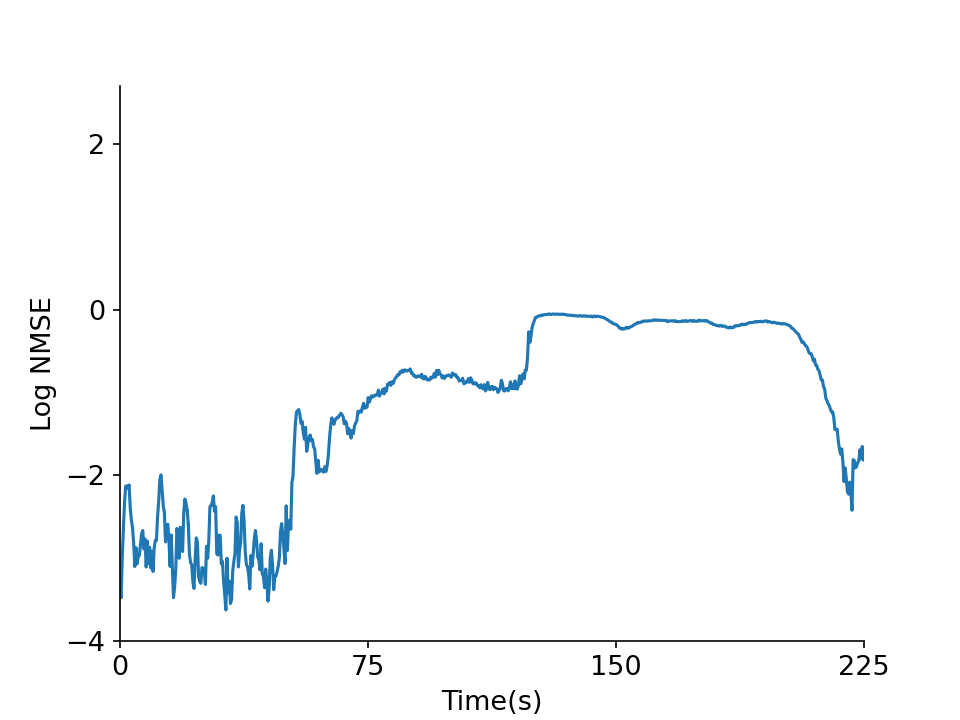

[]


In [102]:
winl=0
winr=1160


nes=13

plt.figure(29)
fig, ax_time=plt.subplots()
ax_time.spines['right'].set_visible(False)
ax_time.spines['top'].set_visible(False)
j=simj
i=see

move=0              ##560
movet=torch.zeros(5,1);
if not shwtyp:
    trant=10
    movet[0]=move/fps/10

for j in range(5):
    kcou[:,j]=torch.tensor(range(500000))
    kcou1[:,j]=torch.tensor(range(500000))
if not shwtyp:
    for j in range(5):
        kcou[:,j]=(kcou[:,j]+move)/fpsarr[j]/10

for j in range(5):
    kcou1[:,j]=(kcou1[:,j]+move)/fpsarr[j] 
    

for j in range(jra):
    if not seealltype:
        j=seej
    names="%d" %j
    locals()["datasol"+names]=locals()["data"+names+"cp"]@traa+cc0

plot_col=[]    
j=simj
statelas2=trst1[winl];
lasswi=winl
name="xxa"+"s"+'%d' %j
locals()["wso"+name]=locals()["w1"+name+"cp"]@traa+cc0

plt.xlim(0,150) # figloss3
plt.ylim(-0.1,2.7) # figloss3
ax_time.set_xticks([0, 75, 150])#floss3
ax_time.set_yticks([0, 1.0, 2.0])#floss3

plt.xlim(0,225) # figloss3
plt.ylim(-4,2.7) # figloss3
ax_time.set_xticks([0, 75, 150, 225])#floss3
ax_time.set_yticks([-4, -2, 0, 2])#floss3

# segleft=round(winl/10)
# segright=round(winr/10)
# print(locals()["wso"+name][segleft*10:10:segright*10,i,:])
#plt.plot(kcou1[segleft:segright,j],torch.norm(locals()["wso"+name][segleft*10:10:segright*10,i,:]-locals()["datasol"+names][i*50+segleft:i*50+segright,:],p=2,dim=1))   

winl2=2600
winr2=3200
segleft2=round(winl2/10)
segright2=round(winr2/10)
segleft3=round(winr/10)
segright3=segleft3+segright2-segleft2
#plt.plot(kcou1[segleft2:segright2,j]-kcou[winl2,j],torch.norm(locals()["wso"+name][segleft2*10:segright2*10:10,i,:]-locals()["datasol"+names][i*50+segleft3:i*50+segright3,:],p=2,dim=1)/torch.norm(locals()["datasol"+names][i*50+segleft3:i*50+segright3,:],p=2,dim=1),'#1f77b4')   
# plt.plot(kcou1[segleft2:segright2,j]-kcou[winl2,j],locals()["datasol"+names][i*50+segleft3:i*50+segright3,13])   
#plt.plot(kcou1[segleft2:segright2,j]-kcou[winl2,j],locals()["wso"+name][segleft2*10:segright2*10:10,i,13])   
plt.plot(kcou1[segleft2:segright2,j]-kcou[winl2,j],torch.log(torch.norm(locals()["wso"+name][segleft2*10:segright2*10:10,i,:]-locals()["datasol"+names][i*50+segleft3:i*50+segright3,:],p=2,dim=1)/torch.norm(locals()["datasol"+names][i*50+segleft3:i*50+segright3,:],p=2,dim=1)),'#1f77b4')   


winl3=3200
winr3=19000
segleft33=round(winl3/10)
segright33=round(winr3/10)
segleft44=round(winr/10+winr2/10-winl2/10-10)
segright44=segleft44+segright33-segleft33
#plt.plot(kcou1[segleft33:segright33,j]-kcou[winl2,j],torch.norm(locals()["wso"+name][segleft33*10:segright33*10:10,i,:]-locals()["datasol"+names][i*50+segleft44:i*50+segright44,:],p=2,dim=1)/torch.norm(locals()["datasol"+names][i*50+segleft44:i*50+segright44,:],p=2,dim=1),'#1f77b4')   
# plt.plot(kcou1[segleft33:segright33,j]-kcou[winl2,j],locals()["datasol"+names][i*50+segleft44:i*50+segright44,13])   
# plt.plot(kcou1[segleft33:segright33,j]-kcou[winl2,j],locals()["wso"+name][segleft33*10:segright33*10:10,i,13])  
plt.plot(kcou1[segleft33:segright33,j]-kcou[winl2,j],torch.log(torch.norm(locals()["wso"+name][segleft33*10:segright33*10:10,i,:]-locals()["datasol"+names][i*50+segleft44:i*50+segright44,:],p=2,dim=1)/torch.norm(locals()["datasol"+names][i*50+segleft44:i*50+segright44,:],p=2,dim=1)),'#1f77b4')   

plt.plot([kcou1[segright2-1,j].item()-kcou[winl2,j].item(),kcou1[segleft33,j].item()-kcou[winl2,j].item()],[torch.log(torch.norm(locals()["wso"+name][segright2*10-10,i,:]-locals()["datasol"+names][i*50+segright3-1,:],p=2)/torch.norm(locals()["datasol"+names][i*50+segright3-1,:],p=2)),torch.log(torch.norm(locals()["wso"+name][segleft33*10,i,:]-locals()["datasol"+names][i*50+segleft44,:],p=2)/torch.norm(locals()["datasol"+names][i*50+segleft44,:],p=2))],'#1f77b4')   

# for k in range(winr2-1):
#     if trst1[k+1]!=statelas2:
#         if k<winl2:
#             continue
#         labeler=statelas2.clone().type(torch.int).item()-1
#         namer="linel"+'%d' %labeler
#         locals()[namer],=plt.plot(kcou[lasswi:k+2,j]+kcou[winr,j]-kcou[winl2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])
#         if not labeler in plot_col:
#             plot_col.append(labeler)
#         lasswi=k+1
#         statelas2=trst1[k+1]   
# labeler=statelas2.clone().type(torch.int).item()-1
# namer="linel"+'%d' %labeler
# locals()[namer],=plt.plot(kcou[lasswi:k+2,j]+kcou[winr,j]-kcou[winl2,j],locals()["wso"+name][lasswi:k+2,i,nes],color=colorname[labeler])   

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Time(s)",fontsize=13)
# plt.ylabel("Loss",fontsize=13)
plt.ylabel("Log NMSE",fontsize=13)
print(plot_col)
# tempar1=[]
# tempar2=[]
Reverse_down=False
# for i in plotarray:
# for i in [6,3,4]:
# for i in [1,0,4,6,3,2]:
# for i in [1,4,6,3,0]:

# plt.legend([line1,line2],["transparent means data","solid means simulated"])


    
# plt.title("trace simulated,moved \n through t axes "+'%.2f' %movet + "s")
# plt.savefig("./pic/show5/5.png",dpi=500)

# savefig_path="./lastout/out-ori/ex1/l5b"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)

# ,loc="upper right"

In [76]:
segright2*10

1500

In [48]:
print(sca_col)

[3]


In [46]:
# see=29
# i=see
# j=0
# name="xxa"+"s"+'%d' %j
# savetr=np.array(locals()["w1"+name+"cp"][winl:winr,:,:])
# io.savemat("./lastout/5/dis_ne=13-simnu=16.mat",{"cy1":savetr}) 


# savest=np.array(trst1)
# io.savemat("./attrpo/tr/cymod3/cycle5st.mat",{"tr2st":savest}) 

In [12]:
def fenduan(tempx):
    for k in range(7):
        if cumleishu[k]<= tempx < cumleishu[k+1]:
            return k+1
def learnst(dataofst,tf,use_type=1):
    if use_type==1:
        trst1=torch.zeros(tfie*10,1)
        for i in range(round(tf/100)):
            tempstgo=stgosorted.repeat(100,1,1)
            tempda=dataofst[i*100:i*100+100,:]
            tempda=tempda.repeat(cumleishu[7],1,1).transpose(0,1)
            tempfd=torch.nn.PairwiseDistance(2)
            tempdis=tempfd(tempstgo,tempda)
            tempar=torch.argmin(tempdis,1)
            tempar=tempar.to(torch.device("cpu"))
            for k in range(100):
                trst1[k+i*100]=fenduan(tempar[k])  
    else:
        trst1=(model2(dataofst[:tf,:]).argmax(1)+1).type(torch.int)
    return trst1 

In [51]:
# extra work 1: calculate state transition probability in different noise level

test_D=1e-2
#模拟曲线模块
my_raodong=0
dis_ne=0
simnu=60
simj=0
j=0
name1="data"+'%d' %j
x1=torch.zeros(simnu,dim)
for i in range(simnu):
    start=50*i
    x1[i,:]=locals()[name1][start]
x1=x1.to(dev)
k=0
name="xxa"+"s"+'%d' %j
locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
stopsig=0
with torch.no_grad():
    for t in range(36000):
        x1=x1+(model(x1)-x1*del2)*delta2/fpsarr[0]
        if t%segm==segm-1:
            rd=torch.randn(simnu,dim)*math.sqrt(delta2/delta1/segm*test_D)
            rd=rd.to(dev)
            x1=x1+rd
            locals()["w1"+name][k,:,:]=x1.detach()
            k=k+1
            if t%1000==999:
                print(t)
locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))


2999
5999
8999
11999
14999
17999
20999
23999
26999
29999
32999
35999


In [52]:
# extra work 1: calculate state transition probability in different noise level
tran_p=torch.zeros(7,7)
for i in range(simnu):
    trst1=learnst(locals()["w1"+name][:,i,:],winr,2)
    trst11=trst1[2000:11000-1]
    trst2=trst1[2001:11000]
    trstdel=trst11-trst2
    for ind in torch.nonzero(trstdel):
        ind=ind[0]
        state1=trst11[ind]
        state2=trst2[ind]
        labeler1=state1.clone().type(torch.int).item()-1
        labeler2=state2.clone().type(torch.int).item()-1
        tran_p[labeler1][labeler2]=tran_p[labeler1][labeler2]+1
    if i%10 == 0:
        print(i)
print(tran_p)

0
10
20
30
40
50
tensor([[   0.,   74.,   19.,   49.,   20.,   28.,    0.],
        [  67.,    0.,  355.,  672.,  191.,  760.,  652.],
        [  29.,  362.,    0., 1759., 1169., 2090., 1930.],
        [  52.,  672., 1833.,    0., 2262.,  102., 4610.],
        [  19.,  194., 1170., 2199.,    0., 2321., 3767.],
        [  24.,  756., 2027.,  102., 2310.,    0., 5973.],
        [   0.,  640., 1937., 4750., 3708., 5894.,    0.]])


In [40]:
tran_p_save=torch.zeros(5,7,7)

In [53]:
tran_p_save[4,:,:]=tran_p

In [19]:
print([1e-6*math.pow(1.5,i) for i in range(30)])

[1e-06, 1.5e-06, 2.25e-06, 3.375e-06, 5.062499999999999e-06, 7.59375e-06, 1.1390624999999999e-05, 1.7085937499999998e-05, 2.562890625e-05, 3.8443359375e-05, 5.76650390625e-05, 8.649755859375e-05, 0.00012974633789062499, 0.0001946195068359375, 0.0002919292602539062, 0.00043789389038085934, 0.000656840835571289, 0.0009852612533569336, 0.0014778918800354003, 0.0022168378200531007, 0.0033252567300796508, 0.004987885095119476, 0.0074818276426792145, 0.011222741464018821, 0.01683411219602823, 0.025251168294042347, 0.03787675244106352, 0.056815128661595285, 0.08522269299239292, 0.12783403948858937]


In [23]:
#extra work1:final

# D_set=[1e-6,3e-6,6e-6,1e-5,3e-5,6e-5,1e-4,3e-4,6e-4,1e-3,3e-3,6e-3,1e-2,3e-2,6e-2,1e-1,3e-1,6e-1,1e-0] #tranp6
D_set=[1e-6*math.pow(1.5,i) for i in range(30)]  #tranp7
D_set_num=len(D_set)
tran_p_save=torch.zeros(D_set_num,7,7)
tranline_p_save=torch.zeros(D_set_num,7)
for l in range(D_set_num):
    test_D=D_set[l]  
    my_raodong=0
    dis_ne=0
    simnu=60
    simj=0
    j=0
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    for i in range(simnu):
        start=50*i
        x1[i,:]=locals()[name1][start]
    x1=x1.to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
    stopsig=0
    with torch.no_grad():
        for t in range(36000):
            x1=x1+(model(x1)-x1*del2)*delta2/fpsarr[0]
            if t%segm==segm-1:
                rd=torch.randn(simnu,dim)*math.sqrt(delta2/delta1/segm*test_D)
                rd=rd.to(dev)
                x1=x1+rd
                locals()["w1"+name][k,:,:]=x1.detach()
                k=k+1
                if t%3000==2999:
                    print(l,test_D,t)
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
    tran_p=torch.zeros(7,7)
    tranline_p=torch.zeros(7)
    for i in range(simnu):
        trst1=learnst(locals()["w1"+name][:,i,:],winr,2)
        trst11=trst1[2000:10000]
        [temp_ele,temp_count]=torch.unique(trst1,return_counts=True)
        tranline_p[temp_ele.type(torch.long)-1]=tranline_p[temp_ele.type(torch.long)-1]+temp_count
        trst11=trst1[2000:11000-1]
        trst2=trst1[2001:11000]
        trstdel=trst11-trst2
        for ind in torch.nonzero(trstdel):
            ind=ind[0]
            state1=trst11[ind]
            state2=trst2[ind]
            labeler1=state1.clone().type(torch.int).item()-1
            labeler2=state2.clone().type(torch.int).item()-1
            tran_p[labeler1][labeler2]=tran_p[labeler1][labeler2]+1
    tran_p_save[l,:,:]=tran_p
    tranline_p_save[l,:]=tranline_p
    print(l,test_D,tran_p)

0 1e-06 2999
0 1e-06 5999
0 1e-06 8999
0 1e-06 11999
0 1e-06 14999
0 1e-06 17999
0 1e-06 20999
0 1e-06 23999
0 1e-06 26999
0 1e-06 29999
0 1e-06 32999
0 1e-06 35999
0 1e-06 tensor([[  0., 759.,   0.,   0.,   0.,   0.,   0.],
        [754.,   0.,   0.,   2.,  15.,   2.,   0.],
        [  2.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  4.,  10.,   0.,   0.,   3.,   0.,   0.],
        [  1.,   1.,   0.,   0.,   0.,   0.,  16.],
        [  0.,   1.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   1.,  15.,   0.,   0.,   0.]])
1 1.5e-06 2999
1 1.5e-06 5999
1 1.5e-06 8999
1 1.5e-06 11999
1 1.5e-06 14999
1 1.5e-06 17999
1 1.5e-06 20999
1 1.5e-06 23999
1 1.5e-06 26999
1 1.5e-06 29999
1 1.5e-06 32999
1 1.5e-06 35999
1 1.5e-06 tensor([[  0., 834.,   0.,   0.,   0.,   1.,   0.],
        [831.,   0.,   0.,   0.,  16.,   2.,   0.],
        [  2.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  5.,  11.,   0.,   0.,   1.,   0.,   0.],
        [  2.,   0.,   0.,   0.,   0.,   0.,  16.],
   

7 1.7085937499999998e-05 2999
7 1.7085937499999998e-05 5999
7 1.7085937499999998e-05 8999
7 1.7085937499999998e-05 11999
7 1.7085937499999998e-05 14999
7 1.7085937499999998e-05 17999
7 1.7085937499999998e-05 20999
7 1.7085937499999998e-05 23999
7 1.7085937499999998e-05 26999
7 1.7085937499999998e-05 29999
7 1.7085937499999998e-05 32999
7 1.7085937499999998e-05 35999
7 1.7085937499999998e-05 tensor([[0.000000000000000e+00, 1.410000000000000e+03, 4.000000000000000e+00,
         6.000000000000000e+00, 1.000000000000000e+00, 1.000000000000000e+00,
         0.000000000000000e+00],
        [1.403000000000000e+03, 0.000000000000000e+00, 0.000000000000000e+00,
         6.000000000000000e+00, 3.600000000000000e+01, 1.800000000000000e+01,
         0.000000000000000e+00],
        [1.200000000000000e+01, 0.000000000000000e+00, 0.000000000000000e+00,
         1.000000000000000e+00, 0.000000000000000e+00, 0.000000000000000e+00,
         4.900000000000000e+01],
        [1.300000000000000e+01, 2.10000

12 0.00012974633789062499 2999
12 0.00012974633789062499 5999
12 0.00012974633789062499 8999
12 0.00012974633789062499 11999
12 0.00012974633789062499 14999
12 0.00012974633789062499 17999
12 0.00012974633789062499 20999
12 0.00012974633789062499 23999
12 0.00012974633789062499 26999
12 0.00012974633789062499 29999
12 0.00012974633789062499 32999
12 0.00012974633789062499 35999
12 0.00012974633789062499 tensor([[0.000000000000000e+00, 3.969000000000000e+03, 4.010000000000000e+02,
         5.000000000000000e+00, 1.600000000000000e+01, 4.840000000000000e+02,
         0.000000000000000e+00],
        [3.965000000000000e+03, 0.000000000000000e+00, 1.400000000000000e+01,
         3.000000000000000e+01, 8.200000000000000e+01, 8.400000000000000e+01,
         0.000000000000000e+00],
        [4.240000000000000e+02, 1.300000000000000e+01, 0.000000000000000e+00,
         2.500000000000000e+01, 2.000000000000000e+00, 8.050000000000000e+02,
         2.890000000000000e+02],
        [1.200000000000000

20 0.0033252567300796508 2999
20 0.0033252567300796508 5999
20 0.0033252567300796508 8999
20 0.0033252567300796508 11999
20 0.0033252567300796508 14999
20 0.0033252567300796508 17999
20 0.0033252567300796508 20999
20 0.0033252567300796508 23999
20 0.0033252567300796508 26999
20 0.0033252567300796508 29999
20 0.0033252567300796508 32999
20 0.0033252567300796508 35999
20 0.0033252567300796508 tensor([[   0.,   32.,   24.,   20.,   11.,   10.,    0.],
        [  33.,    0.,  132.,  170.,   88.,  101.,   29.],
        [  26.,  122.,    0., 1073.,  652., 1234., 1576.],
        [  20.,  183., 1096.,    0., 1089.,    8., 2349.],
        [   8.,   87.,  651.,  961.,    0.,  496., 2293.],
        [  10.,   99., 1136.,    8.,  512.,    0., 3705.],
        [   0.,   30., 1642., 2511., 2140., 3616.,    0.]])
21 0.004987885095119476 2999
21 0.004987885095119476 5999
21 0.004987885095119476 8999
21 0.004987885095119476 11999
21 0.004987885095119476 14999
21 0.004987885095119476 17999
21 0.0049878850

29 0.12783403948858937 17999
29 0.12783403948858937 20999
29 0.12783403948858937 23999
29 0.12783403948858937 26999
29 0.12783403948858937 29999
29 0.12783403948858937 32999
29 0.12783403948858937 35999
29 0.12783403948858937 tensor([[0.000000000000000e+00, 1.006000000000000e+03, 1.930000000000000e+02,
         3.870000000000000e+02, 1.190000000000000e+02, 7.420000000000000e+02,
         3.000000000000000e+00],
        [9.880000000000000e+02, 0.000000000000000e+00, 9.690000000000000e+02,
         5.030000000000000e+03, 1.303000000000000e+03, 7.063000000000000e+03,
         3.387000000000000e+03],
        [1.900000000000000e+02, 9.730000000000000e+02, 0.000000000000000e+00,
         1.716000000000000e+03, 4.900000000000000e+02, 2.296000000000000e+03,
         9.750000000000000e+02],
        [3.940000000000000e+02, 5.015000000000000e+03, 1.660000000000000e+03,
         0.000000000000000e+00, 3.348000000000000e+03, 8.860000000000000e+02,
         4.596000000000000e+03],
        [1.2700000

In [29]:
savetp=np.array(tran_p_save)
savelinetp=np.array(tranline_p_save)
io.savemat("./lastout/extra/tranp7.mat",{"tranp":savetp,"tranlinep":savelinetp})

In [30]:
#extra work2 : calculate state probability for different inhibitions
# neuron_set=[-1,2,4,6]
neuron_set=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13]
neu_num=len(neuron_set)
line_p_save=torch.zeros(neu_num,7)
test_D=6e-4
dis_coe=0.1
for l in range(neu_num):
    dis_ne=neuron_set[l]  
    simnu=60
    simj=0
    j=0
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    for i in range(simnu):
        start=50*i
        x1[i,:]=locals()[name1][start]
    x1=x1.to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(100000,simnu,dim).to(dev)
    stopsig=0
    with torch.no_grad():
        dis_e=torch.zeros(dim,1)
        dis_e[dis_ne]=1
        dis_coe1=cc0@dis_e
        dis_coe1=dis_coe1.item()
        dis_tr=traa@dis_e
        dis_tr2=dis_e.T@trab
        dis_e=dis_e.to(dev)
        dis_tr=dis_tr.to(dev)
        dis_tr2=dis_tr2.to(dev)
        dis_coe2=dis_tr.T@dis_tr
        dis_coe2=dis_coe2.item()
        if dis_ne<0:
            dis_tr2=dis_tr2*0
        for t in range(36000):
            x1=x1+(model(x1)-x1*del2-10*(x1@dis_tr+dis_coe1)*dis_tr2*dis_coe)*delta2/fpsarr[0]
            if t%segm==segm-1:
                rd=torch.randn(simnu,dim)*math.sqrt(delta2/delta1/segm*test_D)
                rd=rd.to(dev)
                x1=x1+rd
                locals()["w1"+name][k,:,:]=x1.detach()
                k=k+1
                if t%3000==2999:
                    print(l,test_D,t)
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
    line_p=torch.zeros(7)
    for i in range(simnu):
        trst1=learnst(locals()["w1"+name][:,i,:],winr,2)
        trst11=trst1[2000:10000]
        [temp_ele,temp_count]=torch.unique(trst1,return_counts=True)
        line_p[temp_ele.type(torch.long)-1]=line_p[temp_ele.type(torch.long)-1]+temp_count
    line_p_save[l,:]=line_p
    print(l,dis_ne,line_p)

0 0.0006 2999
0 0.0006 5999
0 0.0006 8999
0 0.0006 11999
0 0.0006 14999
0 0.0006 17999
0 0.0006 20999
0 0.0006 23999
0 0.0006 26999
0 0.0006 29999
0 0.0006 32999
0 0.0006 35999
0 -1 tensor([111317., 108545.,  66937.,  67795.,  36948.,  35708., 256750.])
1 0.0006 2999
1 0.0006 5999
1 0.0006 8999
1 0.0006 11999
1 0.0006 14999
1 0.0006 17999
1 0.0006 20999
1 0.0006 23999
1 0.0006 26999
1 0.0006 29999
1 0.0006 32999
1 0.0006 35999
1 0 tensor([ 31391.,  61962.,   1599.,   1940., 186165., 116311., 284632.])
2 0.0006 2999
2 0.0006 5999
2 0.0006 8999
2 0.0006 11999
2 0.0006 14999
2 0.0006 17999
2 0.0006 20999
2 0.0006 23999
2 0.0006 26999
2 0.0006 29999
2 0.0006 32999
2 0.0006 35999
2 1 tensor([1.076400000000000e+04, 4.813200000000000e+04, 1.700000000000000e+02,
        1.965000000000000e+03, 6.530000000000000e+02, 6.057100000000000e+04,
        5.617450000000000e+05])
3 0.0006 2999
3 0.0006 5999
3 0.0006 8999
3 0.0006 11999
3 0.0006 14999
3 0.0006 17999
3 0.0006 20999
3 0.0006 23999
3 0.0006 

In [28]:
torch.set_printoptions(precision=2)
for l in range(neu_num):
    dis_ne=neuron_set[l]  
    line_p=line_p_save[l,:]
    line_p=line_p/line_p.sum()
    print(dis_ne,line_p)
torch.set_printoptions(precision=15)

-1 tensor([0.18, 0.18, 0.09, 0.09, 0.05, 0.05, 0.36])
0 tensor([0.03, 0.05, 0.00, 0.00, 0.38, 0.18, 0.35])
1 tensor([1.36e-02, 8.33e-02, 6.43e-04, 3.66e-03, 7.00e-04, 7.55e-02, 8.23e-01])
2 tensor([0.16, 0.20, 0.05, 0.22, 0.05, 0.04, 0.29])
3 tensor([0.27, 0.16, 0.06, 0.20, 0.24, 0.04, 0.03])
4 tensor([0.28, 0.09, 0.01, 0.30, 0.19, 0.03, 0.10])
5 tensor([0.33, 0.02, 0.07, 0.11, 0.09, 0.02, 0.36])
6 tensor([0.03, 0.03, 0.16, 0.17, 0.05, 0.16, 0.42])
7 tensor([0.17, 0.03, 0.02, 0.00, 0.03, 0.05, 0.69])
8 tensor([0.06, 0.03, 0.15, 0.12, 0.07, 0.07, 0.51])
9 tensor([0.07, 0.17, 0.08, 0.12, 0.03, 0.05, 0.48])
10 tensor([0.09, 0.06, 0.01, 0.00, 0.01, 0.73, 0.11])
11 tensor([0.03, 0.07, 0.03, 0.07, 0.53, 0.11, 0.14])
12 tensor([0.05, 0.14, 0.20, 0.01, 0.00, 0.08, 0.51])
13 tensor([0.08, 0.08, 0.06, 0.02, 0.01, 0.07, 0.68])


In [31]:
torch.set_printoptions(precision=2)
for l in range(neu_num):
    dis_ne=neuron_set[l]  
    line_p=line_p_save[l,:]
    line_p=line_p/line_p.sum()
    print(dis_ne,line_p)
torch.set_printoptions(precision=15)

-1 tensor([0.16, 0.16, 0.10, 0.10, 0.05, 0.05, 0.38])
0 tensor([0.05, 0.09, 0.00, 0.00, 0.27, 0.17, 0.42])
1 tensor([1.57e-02, 7.04e-02, 2.49e-04, 2.87e-03, 9.55e-04, 8.86e-02, 8.21e-01])
2 tensor([0.19, 0.21, 0.04, 0.20, 0.05, 0.03, 0.27])
3 tensor([0.27, 0.17, 0.04, 0.21, 0.26, 0.03, 0.03])
4 tensor([0.25, 0.06, 0.02, 0.34, 0.18, 0.04, 0.11])
5 tensor([0.34, 0.02, 0.06, 0.09, 0.09, 0.02, 0.38])
6 tensor([0.03, 0.02, 0.15, 0.14, 0.05, 0.16, 0.44])
7 tensor([0.17, 0.04, 0.02, 0.00, 0.03, 0.05, 0.68])
8 tensor([0.05, 0.02, 0.16, 0.11, 0.07, 0.07, 0.53])
9 tensor([0.05, 0.14, 0.08, 0.13, 0.04, 0.04, 0.51])
10 tensor([0.09, 0.05, 0.01, 0.00, 0.01, 0.74, 0.11])
11 tensor([0.04, 0.09, 0.03, 0.07, 0.51, 0.12, 0.15])
12 tensor([0.04, 0.11, 0.23, 0.00, 0.00, 0.10, 0.52])
13 tensor([0.11, 0.09, 0.06, 0.02, 0.00, 0.06, 0.66])


In [32]:
savetp=np.array(line_p_save)
io.savemat("./lastout/extra/linep2_2.mat",{"linep":savetp})

tensor(2.904629707336426)

In [60]:
# esti D in special case

my_loss_fn = torch.nn.MSELoss(reduction='sum')
i=tr_num_learn
name="data"+'%d' %i
with torch.no_grad():
    xpre=locals()[name][0:reclen[i]-ss-2].to(dev)
    for j in range(segm):
        xpre=xpre+(model(xpre)-xpre*del2)*delta1/fpsarr[i]
    temp1=locals()[name][1:reclen[i]-ss-2+1]
    my_temp_D = my_loss_fn(temp1,xpre.to(torch.device("cpu")))*(fpsarr[i]/2)/dim/(reclen[i]-ss-3)

print(my_temp_D)
        
my_D=my_temp_D.to(dev)

tensor(0.000640914018732)


In [162]:
# train the attraction and sigma 

simnu=60
for j in range(kra):
    if not simtype:
        j=simj
    name1="data"+'%d' %j
    x1=torch.zeros(simnu,dim)
    temp5=torch.zeros(simnu)
    for i in range(simnu):
        start=50*i
        x1[i,:]=locals()[name1][start]
    x1=x1.to(dev)
    sigmae=torch.zeros(simnu,dim,dim).to(dev)
    my_I=torch.eye(dim).to(dev)
    my_A=torch.zeros(simnu,dim,dim).to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(50000,simnu,dim)
    locals()["simsigma"+name]=torch.zeros(50000,simnu,dim,dim)
    for temp3 in range(simnu):
        sigmae[temp3]=my_I*my_D
    for t in range(36000):
#         x1.requires_grad=True
#         for j in range(dim):
#             y1=model(x1)-del2*x1
#             if j>0:
#                 x1.grad.zero_()
#             y1jsum=torch.sum(y1[:,j])
#             y1jsum.backward()
#             my_A[:,j,:]=x1.grad
        with torch.no_grad():
#             sigmae=sigmae+(sigmae@torch.transpose(my_A,1,2)+my_A@sigmae+2*my_D/segm/delta1*my_I)*delta2
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                locals()["w1"+name][k,:,:]=x1.detach()
                if k%50 == 49: 
                    for j in range(simnu):
                        if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-40,j,:])>1e-4:
                            temp5[j]=0
                        if torch.dist(locals()["w1"+name][k,j,:],locals()["w1"+name][k-40,j,:])<1e-4 and temp5[j]<1:
                            print(k,j,locals()["w1"+name][k,j,:])
                            temp5[j]=2
                k=k+1
                if t%1000==999:
                    print(t,"wow")
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))

stopk=0

for j in range(simnu):
    if temp5[j]>1:
        stopk=stopk+1
print(stopk)


199 12 tensor([-0.587345361709595,  0.187760725617409,  0.082177504897118,
         0.434640020132065, -0.251423686742783, -0.090733870863914,
         0.015469253063202, -0.002353208838031,  0.041046481579542,
        -0.035256970673800,  0.028578229248524, -0.026484278962016,
         0.015790166333318, -0.004806162323803])
199 16 tensor([ 9.035912156105042e-02, -9.017639607191086e-02,  3.931545317173004e-01,
        -6.271504610776901e-02,  1.180307492613792e-01, -7.430476695299149e-02,
        -7.641422748565674e-02,  7.926895469427109e-02, -1.912466883659363e-01,
         8.165789395570755e-02,  8.650073409080505e-02,  3.055265173316002e-02,
        -2.815740182995796e-02,  7.828303932910785e-05])
199 29 tensor([ 0.359029501676559,  0.001721167238429,  0.031204832717776,
         0.131930068135262,  0.143921986222267,  0.091168336570263,
        -0.081582143902779, -0.027032794430852, -0.027142444625497,
         0.025764195248485,  0.022835772484541, -0.060909941792488,
        -

599 22 tensor([-0.321507841348648, -0.208529084920883,  0.014841080643237,
         0.217735439538956,  0.079589731991291, -0.073227785527706,
         0.045672196894884, -0.027235021814704, -0.041786950081587,
         0.021995726972818, -0.023643987253308, -0.009477173909545,
         0.016705105081201,  0.002983951941133])
599 28 tensor([ 0.377992093563080,  0.009578569792211,  0.062523014843464,
         0.128650143742561,  0.139928683638573,  0.120438985526562,
        -0.086700640618801, -0.053104992955923, -0.021645890548825,
         0.019877860322595,  0.024652132764459, -0.050182446837425,
         0.010898252949119, -0.022356403991580])
599 34 tensor([-0.321520596742630, -0.208530619740486,  0.014838205650449,
         0.217742219567299,  0.079580575227737, -0.073228955268860,
         0.045664060860872, -0.027248326689005, -0.041777860373259,
         0.021998727694154, -0.023641185835004, -0.009472893550992,
         0.016709001734853,  0.002984104910865])
649 4 tensor([-0

8999 wow
3849 6 tensor([ 0.439532339572906,  0.003147927578539,  0.107350580394268,
         0.058018203824759,  0.050099551677704,  0.153844401240349,
        -0.122145690023899,  0.014597566798329, -0.051916252821684,
         0.014738268218935,  0.040644001215696, -0.018616311252117,
        -0.045164350420237, -0.013391785323620])
11999 wow
4799 5 tensor([ 0.439532339572906,  0.003147618612275,  0.107350364327431,
         0.058018285781145,  0.050099305808544,  0.153844639658928,
        -0.122145749628544,  0.014597383327782, -0.051916312426329,
         0.014738341793418,  0.040643937885761, -0.018616052344441,
        -0.045164540410042, -0.013391663320363])
14999 wow


KeyboardInterrupt: 

In [151]:
# train the sigma 


for j in range(kra):
    if not simtype:
        j=simj
    name1="data"+'%d' %j
    x1=torch.zeros(stopk,dim)
    temp1=0
    for i in range(simnu):
        start=50*i
        if temp5[i]>1:
            x1[temp1,:]=locals()[name1][start]
            temp1=temp1+1
    x1=x1.to(dev)
    sigmae=torch.zeros(stopk,dim,dim).to(dev)
    my_I=torch.eye(dim).to(dev)
    my_A=torch.zeros(stopk,dim,dim).to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(50000,stopk,dim)
    locals()["simsigma"+name]=torch.zeros(50000,stopk,dim,dim)
    for temp3 in range(stopk):
        sigmae[temp3]=my_I*my_D
    for t in range(12000):
        x1.requires_grad=True
        for j in range(dim):
            y1=model(x1)-del2*x1
            if j>0:
                x1.grad.zero_()
            y1jsum=torch.sum(y1[:,j])
            y1jsum.backward()
            my_A[:,j,:]=x1.grad
        with torch.no_grad():
            sigmae=sigmae+(sigmae@torch.transpose(my_A,1,2)+my_A@sigmae+2*my_D/segm/delta1*my_I)*delta2
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                locals()["w1"+name][k,:,:]=x1.detach()
                locals()["simsigma"+name][k,:,:,:]=sigmae.detach()
                k=k+1
                if t%1000==999:
                    print(t,"wow")
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            

999 wow
1999 wow
2999 wow
3999 wow
4999 wow
5999 wow
6999 wow
7999 wow
8999 wow
9999 wow
10999 wow
11999 wow


In [23]:
import scipy.io as io
for i in range(stopk):
    print(locals()["simsigma"+name][3900,i,:,:],locals()["simsigma"+name][3900,i,:,:]-locals()["simsigma"+name][3800,i,:,:])
    
torch.save(locals()["simsigma"+name],"./attrpo/modqig_seg2st1ss2verynice/sig.pth")     
torch.save(locals()["w1"+name],"./attrpo/modqig_seg2st1ss2verynice/poi.pth")     
torch.save(temp5,"./attrpo/modqig_seg2st1ss2verynice/temp5.pth")     
savesigma=np.array(locals()["simsigma"+name][3900,:,:,:])
io.savemat("./attrpo/modqig_seg2st1ss2verynice/sig.mat",{"simsigma":savesigma})            
savepoi=np.array(locals()["w1"+name][3900,:,:])
io.savemat("./attrpo/modqig_seg2st1ss2verynice/poi.mat",{"simpoi":savepoi})
savetemp5=np.array(temp5)
io.savemat("./attrpo/modqig_seg2st1ss2verynice/temp5.mat",{"temp5":savetemp5})     
    
    

NameError: name 'stopk' is not defined

In [33]:
# train the sigma of cycle

for j in range(kra):
    if not simtype:
        j=simj
    name1="data"+'%d' %j
    x1=torch.zeros(1,dim)
    temp1=0
    x1[temp1,:]=locals()[name1][100]
    x1=x1.to(dev)
    sigmae=torch.zeros(1,dim,dim).to(dev)
    my_I=torch.eye(dim).to(dev)
    my_A=torch.zeros(1,dim,dim).to(dev)
    k=0
    name="xxa"+"s"+'%d' %j
    locals()["w1"+name]=torch.zeros(50000,1,dim)
    locals()["simsigma"+name]=torch.zeros(50000,1,dim,dim)
    for temp3 in range(1):
        sigmae[temp3]=my_I*my_D
    for t in range(12000):
        x1.requires_grad=True
        for j in range(dim):
            y1=model(x1)-del2*x1
            if j>0:
                x1.grad.zero_()
            y1jsum=torch.sum(y1[:,j])
            y1jsum.backward()
            my_A[:,j,:]=x1.grad
        with torch.no_grad():
            sigmae=sigmae+(sigmae@torch.transpose(my_A,1,2)+my_A@sigmae+2*my_D/segm/delta1*my_I)*delta2
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                rd=torch.randn(1,dim)*(5e-4)
                rd=rd.to(dev)
                x1=x1+rd
                locals()["w1"+name][k,:,:]=x1.detach()
                locals()["simsigma"+name][k,:,:,:]=sigmae.detach()
                k=k+1
                if t%1000==999:
                    print(t,"wow")
    locals()["w1"+name+"cp"]=locals()["w1"+name].to(torch.device("cpu"))
            
        

999 wow
1999 wow
2999 wow
3999 wow
4999 wow
5999 wow
6999 wow
7999 wow
8999 wow
9999 wow
10999 wow
11999 wow


In [35]:
import scipy.io as io
for i in range(1):
    print(locals()["simsigma"+name][3900,i,:,:],locals()["simsigma"+name][3900,i,:,:]-locals()["simsigma"+name][3800,i,:,:])
    
savesigma=np.array(locals()["simsigma"+name][0:4000,:,:,:])
io.savemat("./attrpo/mod/cycle/sigcy.mat",{"simsigmacy":savesigma})            
savepoi=np.array(locals()["w1"+name][0:4000,:,:])
io.savemat("./attrpo/mod/cycle/poicy.mat",{"simpoicy":savepoi})
# savetemp5=np.array(temp5)
# io.savemat("./attrpo/mod/cycle/temp5.mat",{"temp5cy":savetemp5})     
    

tensor([[ 3.032555687241256e-04,  4.374184572952799e-05, -4.558370346785523e-05,
         -5.200414670980535e-05, -6.693178420391632e-06,  9.027172927744687e-05,
          1.904172313516028e-05, -8.619998698122799e-05, -1.493320723966463e-05,
         -8.559654816053808e-05, -7.822545740054920e-05, -6.512783875223249e-05,
         -7.429693505400792e-05, -5.582154335570522e-05],
        [ 4.374184572952799e-05,  4.285291652195156e-04, -2.916691846621688e-05,
          1.392750418744981e-04, -5.387667624745518e-05,  1.815473369788378e-04,
         -1.931506703840569e-04, -2.549318887759000e-04, -8.848622383084148e-05,
          2.027308219112456e-04, -4.972927272319794e-04, -4.424430517246947e-05,
         -2.901439438574016e-04, -1.379484019707888e-04],
        [-4.558370346785523e-05, -2.916691846621688e-05,  3.671642043627799e-04,
          1.956346750375815e-05,  8.224301564041525e-05, -1.224345032824203e-04,
          8.148391498252749e-05,  8.250663086073473e-05,  7.72772546042688

NameError: name 'temp5' is not defined

In [107]:


j=0
i=2
name="xxa"+'%d' %i+"s"+'%d' %j

temp1=0
for t in range(4000):
    if torch.dist(locals()["w1"+name][t,:],locals()["w1"+name][t+1,:])<3e-3:
        temp1=temp1+1
    else:
        temp1=0
    if temp1>10:
        print(t)
        temp1=0
        
        

177
188
199
210
221
232
243
254
265
276
287
298
309
320
331
342
353
364
375
386
397
408
419
430
441
452
463
474
485
496
507
527
538
549
560
571
582
593
604
615
626
637
648
659
670
681
692
703
961
981
1064
1429
1450
1461
1472
1483
1494
1505
1516
1527
1538
1549
1560
1571
1582
1593
2310
2321
2332
2343
2354
2365
2376
2387
2398
2409
2420
2431
2442
2453
2464
2475
2486
2497
2508
2519
2530
2541
2552
2563
2575
2589
2600
2611
2622
2633
2953
2972
3352
3363
3374
3385
3396
3407
3418
3429
3440
3451
3462
3473
3484
3495
3506
3517
3528
3539
3550
3561
3572
3583
3594
3605
3616
3627
3638
3964


In [139]:
#模拟曲线模块
delta2=0.05/segm
kcou=torch.zeros(500000,1)
xxb1=torch.zeros(500000,1)
xxb2=torch.zeros(500000,1)
xxb3=torch.zeros(500000,1)
k=0
move=100

lista1=[3,3,3,1,1]
lista2=[120,1900,3650,1450,3300]

for j in range(1):
    for i in range(20):
        if i<15:
            continue
        temp1=lista1[i-15]
        start=lista2[i-15]
        name1="xxa"+'%d' %temp1+"s"+'%d' %j
        x1 = locals()["w1"+name1][start]
        k=0
        name="xxa"+'%d' %i+"s"+'%d' %j
        locals()["w1"+name]=torch.zeros(100000,dim)
        stopsig=0
        for t in range(20000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                kcou[k]=k+move;
                x1=x1+torch.randn(dim)*(5e-4)
#                 x1=x1+torch.randn(dim)*(3e-3)
                locals()["w1"+name][k,0:dim]=x1.detach()
                k=k+1
                if loss_fn(lastx1,x1)<1e-3 and stopsig==0:
                    print(i,t,x1)        
                    stopsig=1
                else :
                    if loss_fn(lastx1,x1)>1e-3:
                        stopsig=0
            lastx1=x1
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1

15 2 tensor([ 0.43611115, -0.08734159,  0.11119140,  0.00816380, -0.00592959,
         0.33341023, -0.17645636, -0.04109182, -0.14277001, -0.00275879,
        -0.06330946,  0.05989858, -0.02647080,  0.04313899],
       grad_fn=<AddBackward0>)
16 2 tensor([-3.45788240e-01, -2.36075208e-01,  4.85044718e-03,  1.24221116e-01,
        -1.02409087e-01,  2.75647175e-02,  9.68389288e-02,  1.27508044e-02,
        -2.20256094e-02,  5.30403815e-02,  2.90372618e-03,  1.63250789e-02,
        -3.26433976e-04, -1.16688553e-02], grad_fn=<AddBackward0>)
17 2 tensor([ 0.47273228, -0.00926105,  0.34708473, -0.06719208,  0.07654278,
         0.23495699, -0.18791646, -0.00133568, -0.13930203,  0.03167926,
         0.05310422,  0.06203688, -0.08818529,  0.03017955],
       grad_fn=<AddBackward0>)
18 2 tensor([ 0.47421026, -0.03720672,  0.30679506, -0.07143489,  0.05637535,
         0.23765650, -0.19329816, -0.01636260, -0.10680565,  0.00411327,
         0.04839814,  0.05205306, -0.08978207,  0.02443202],
  

In [35]:
#模拟曲线模块
delta2=0.05/segm
stpoi=torch.zeros(dim,5000)
temp1=0

for j in range(1):
    for i in range(60):
#         i=2
        temprd=torch.randn(dim)
        temprd=temprd/torch.norm(temprd)
#         x1 = w1xxa2s0[500]+temprd*(5e-2)
        x1=data0[50*i]
        k=0
        name="xxa"+'%d' %i+"s"+'%d' %j
        locals()["w2"+name]=torch.zeros(100000,dim)
        stopsig=0
        lastx1=x1
        for t in range(8000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
#                 kcou[k]=k+move;
                x1=x1+torch.randn(dim)*(2e-4)
#                 x1=x1+torch.randn(dim)*(3e-3)
                locals()["w2"+name][k,0:dim]=x1.detach()
                k=k+1
                if t%150==149:                
                    if torch.dist(lastx1,x1)<5e-3 and stopsig==0:
                        temp1=temp1+1
                        print(i,t,x1)
                        stpoi[:,temp1]=x1
                        stopsig=1
                    else :
                        if torch.dist(lastx1,x1)>2e-2:
                            stopsig=0
                    lastx1=x1
        print(i)
    
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


0 899 tensor([-0.357140988111496, -0.275405198335648,  0.059195924550295,
         0.104102857410908, -0.033521719276905, -0.003922943957150,
         0.075166024267673,  0.040766000747681, -0.034353028982878,
        -0.042729817330837,  0.018706662580371, -0.009782931767404,
         0.021594841033220, -0.011263248510659], grad_fn=<AddBackward0>)
0
1 1049 tensor([ 0.439587712287903, -0.136310279369354, -0.125589072704315,
         0.105189442634583, -0.058348849415779,  0.397758960723877,
        -0.203978776931763, -0.028944740071893, -0.115079037845135,
        -0.058666858822107, -0.128446504473686,  0.027194323018193,
        -0.020295372232795,  0.054508272558451], grad_fn=<AddBackward0>)
1
2 899 tensor([-0.382972776889801,  0.014460074715316,  0.401095479726791,
         0.160638153553009, -0.110936634242535, -0.095438458025455,
        -0.002293191384524, -0.019395727664232, -0.042959425598383,
        -0.056628741323948,  0.185587316751480,  0.025911452248693,
         0.0262

19
20 599 tensor([-0.370380014181137, -0.098626665771008,  0.094962894916534,
         0.267464846372604, -0.079394273459911, -0.073468923568726,
         0.005016985349357, -0.046423137187958,  0.011661733500659,
         0.045547194778919,  0.016898423433304, -0.005633029621094,
         0.009500559419394,  0.002940475940704], grad_fn=<AddBackward0>)
20
21 749 tensor([ 5.030392408370972e-01,  4.263776540756226e-02, -6.426998972892761e-02,
         1.439590901136398e-01,  6.793367862701416e-02,  1.295104324817657e-01,
        -1.019934713840485e-01, -2.828046493232250e-02, -4.849937558174133e-02,
         2.364068478345871e-02, -2.891806070692837e-04, -8.926186710596085e-02,
        -2.834455296397209e-02, -1.725197955965996e-02],
       grad_fn=<AddBackward0>)
21
22 1499 tensor([-0.320720940828323, -0.208032250404358,  0.015514416620135,
         0.217541053891182,  0.080434046685696, -0.072456881403923,
         0.044999510049820, -0.025903917849064, -0.041584271937609,
         0.0

KeyboardInterrupt: 

In [36]:
#模拟曲线模块
delta2=0.05/segm
temp1=0

stpoitr=torch.zeros(5000)

for j in range(1):
    for i in range(tt):
        temprd=torch.randn(dim)
        temprd=temprd/torch.norm(temprd)
        x1 = stpoi[:,i+1]+temprd*(5e-2)
        name="xxa"+'%d' %i+"s"+'%d' %j
        for l in range(10):
            for t in range(4000):
                x1=x1+(model(x1)-x1*del2)*delta2
                if t%segm==segm-1:
                    x1=x1+torch.randn(dim)*(2e-4)
#                     x1=x1+torch.randn(dim)*(3e-3)
                    if t%150==149:                
                        if torch.dist(stpoi[:,i+1],x1)>5e-2:
                            stpoitr[i]=stpoitr[i]+1
                            break
                

        print(i,stpoitr[i])
    
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


0 tensor(0.)


KeyboardInterrupt: 

In [63]:
#模拟曲线模块
delta2=0.05/segm
temp1=0

tt=60
stpoi=torch.zeros(dim,61)
for i in range(tt):
    name="xxa"+"s"+'%d' %j
    stpoi[:,i+1]=locals()["w1"+name+"cp"][11000,i,:]
stpoi=stpoi.to(dev)




stpoitr2=torch.zeros(5000)
test_n=100
for j in range(1):
    for i in range(tt):
        x1=torch.zeros(test_n,dim)
        x1_done=torch.zeros(test_n)
        for mn_times in range(test_n):
            x1[mn_times,:] = stpoi[:,i+1]+torch.randn(1,dim).to(dev)*(4e-3)
        x1=x1.to(dev)
        for t in range(6000):
            x1=x1+(model(x1)-x1*del2)*delta2
            if t%segm==segm-1:
                if t%1500==1499:
                    for mn_times in range(test_n):
                        if x1_done[mn_times]!=0:
                            continue
                        if torch.dist(stpoi[:,i+1],x1[mn_times,:])>3e-2:
                            stpoitr2[i]=stpoitr2[i]+1
                            x1_done[mn_times]=1
                

        print(i,stpoitr2[i])
    
#         locals()["w1"+name][k-1,0]=1
#         locals()["w2"+name][k-1,0]=1
#         locals()["w3"+name][k-1,0]=1


0 tensor(0.)
1 tensor(6.)
2 tensor(34.)
3 tensor(32.)
4 tensor(0.)
5 tensor(8.)
6 tensor(3.)
7 tensor(5.)
8 tensor(8.)
9 tensor(7.)
10 tensor(6.)
11 tensor(0.)
12 tensor(0.)
13 tensor(0.)
14 tensor(0.)
15 tensor(31.)
16 tensor(14.)
17 tensor(0.)
18 tensor(6.)
19 tensor(0.)
20 tensor(0.)
21 tensor(0.)
22 tensor(0.)
23 tensor(0.)
24 tensor(9.)
25 tensor(0.)
26 tensor(0.)
27 tensor(0.)
28 tensor(0.)
29 tensor(1.)
30 tensor(0.)
31 tensor(0.)
32 tensor(0.)
33 tensor(0.)
34 tensor(0.)
35 tensor(0.)
36 tensor(0.)
37 tensor(0.)
38 tensor(0.)
39 tensor(0.)
40 tensor(0.)
41 tensor(0.)
42 tensor(0.)
43 tensor(0.)
44 tensor(0.)
45 tensor(10.)
46 tensor(0.)
47 tensor(0.)
48 tensor(0.)
49 tensor(7.)
50 tensor(0.)
51 tensor(0.)
52 tensor(5.)
53 tensor(3.)
54 tensor(3.)
55 tensor(0.)
56 tensor(16.)
57 tensor(0.)
58 tensor(0.)
59 tensor(60.)


<IPython.core.display.Javascript object>


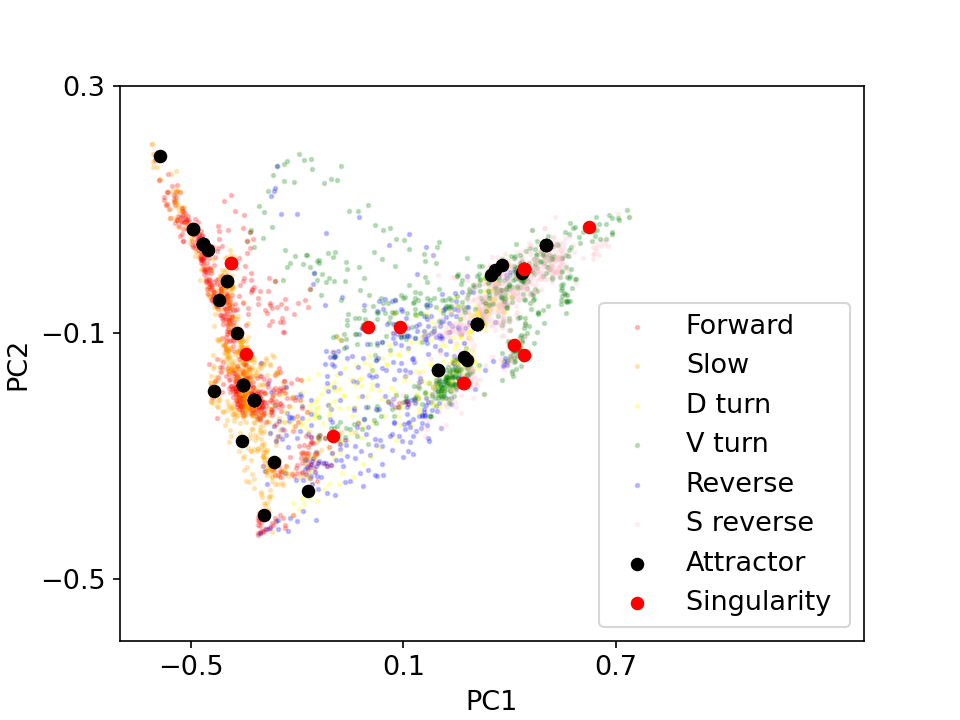

In [67]:
plt.figure(161)

state1=trst1=learnst(data0.to(dev),3000)
statelas1=state1[0];
lasswi=0
for k in range(3000):
    if state1[k+1]!=statelas1:
        labeler=statelas1.clone().type(torch.int).item()-1
        name="linel"+'%d' %labeler
        locals()[name]=plt.scatter(data0[lasswi:k+2,0],data0[lasswi:k+2,1],s=3,color=colorname[labeler],alpha=0.2)
#         plt.plot(data0[lasswi:k+2,0:1],data0[lasswi:k+2,1:2],color=colorname[statelas1.clone().type(torch.int).item()-1],alpha=0.3)
        lasswi=k+1
        statelas1=state1[k+1]




# for tt in range(100):
#     if stpoi[0,tt+1]==0:
#         break;

# print(tt)

stpoicp=stpoi.to(torch.device("cpu"))

for t in range(tt):
    mindis=100;colabel=0;
#     for i in range(7):
#         for j in range(leishu[i]):
#             if torch.dist(stpoi[:,t+1],stcogo[:,stcoar[j,i].clone().type(torch.int)-1,i])<mindis:
#                 mindis=torch.dist(stpoi[:,t+1],stcogo[:,stcoar[j,i].clone().type(torch.int)-1,i])
#                 colabel=i+1

#     print(stpoi[:,t+1],stcogo[:,stcoar[j,i].clone().type(torch.int)-1,i])

#     plt.scatter(stpoi[0,t+1].detach(),stpoi[1,t+1].detach(),s=30,color=colorname[colabel-1])
    if stpoitr2[t]<=3:
        linel9=plt.scatter(stpoicp[0,t+1].detach(),stpoicp[1,t+1].detach(),s=30,color="black")
    else:
        linel10=plt.scatter(stpoicp[0,t+1].detach(),stpoicp[1,t+1].detach(),s=30,color="red")

    
# linel9=plt.scatter(stpoi[0,1:tt].detach(),stpoi[1,1:tt].detach(),s=30,color="black")


plt.legend([linel0,linel1,linel2,linel3,linel4,linel6,linel9,linel10],["Forward","Slow","D turn","V turn","Reverse","S reverse","Attractor","Singularity "],fontsize=13)
plt.xlim([-0.7,1.4])
plt.ylim([-0.6,0.3])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("PC1",fontsize=13)
plt.ylabel("PC2",fontsize=13)
ax=plt.gca()
ax.set_xticks([-0.5, 0.1, 0.7])
ax.set_yticks([-0.5, -0.1, 0.3])

# savefig_path="./lastout/out-ori/2c"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)


# plt.title("the small points are data")
# plt.savefig("./pic/show5/21.png",dpi=500)

<IPython.core.display.Javascript object>


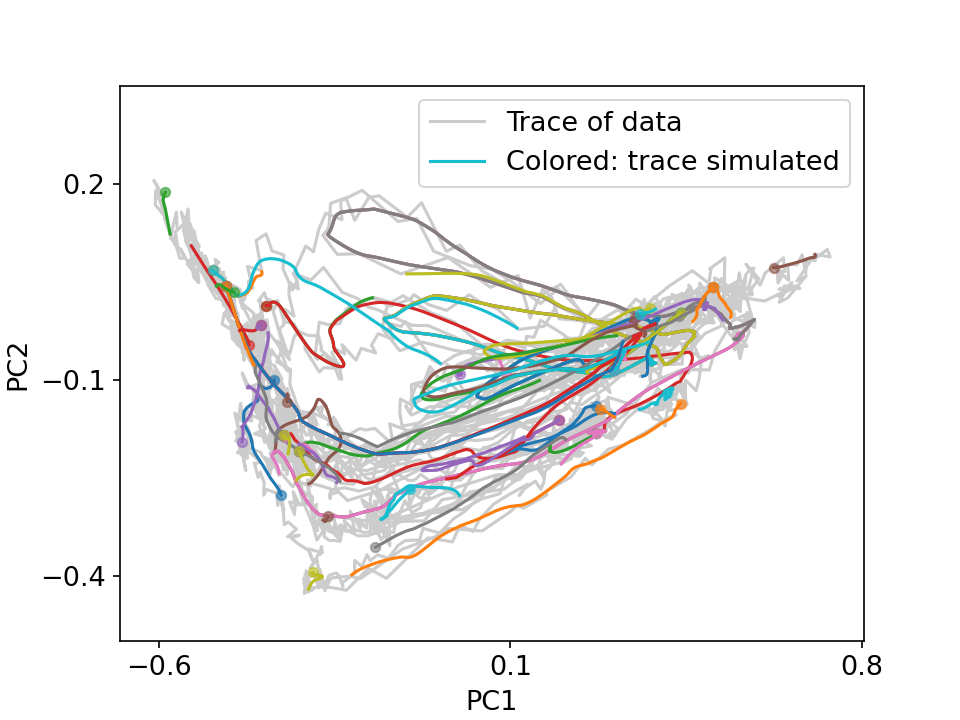

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.164153218269348e-10)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(3.134578430152857e-10)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.000590187730268)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.000967190600932)
tensor(0.)
tensor(0.)
tensor(0.)


In [61]:
plt.figure(160)

line1,=plt.plot(data0[0:3000,0:1],data0[0:3000,1:2],color="gray",alpha=0.4)

plt.xlabel("PC1")
plt.ylabel("PC2")
ax=plt.gca()
ax.set_xticks([-0.6, 0.1, 0.8])
ax.set_yticks([-0.4, -0.1, 0.2])
plt.ylim(-0.5,0.35)
tempcount=0

for j in range(1):
    for i in range(60):
        name="xxa"+"s"+'%d' %j
        line2,=plt.plot(locals()["w1"+name+"cp"][0:12000,i,0].squeeze(-1),locals()["w1"+name+"cp"][0:12000,i,1].squeeze(-1))
        line2.set_zorder(1)
        line1.set_zorder(0)
        plt.scatter(locals()["w1"+name+"cp"][winr-1,i,0].detach(),locals()["w1"+name+"cp"][winr-1,i,1].detach(),s=20,alpha=0.6)
#         line2,=plt.plot(locals()["w1"+name][winl:winr,0:1].squeeze(-1),locals()["w1"+name][winl:winr,1:2].squeeze(-1))        
        
# plt.title("each color means a trace we simulated\n and the point means the end of the trace")
# plt.legend([line1,line2],["trace of data","and others: trace simulated"])
        plt.legend([line1,line2],["Trace of data","Colored: trace simulated"],fontsize=13)
        print(torch.dist(locals()["w1"+name+"cp"][10000,i],locals()["w1"+name+"cp"][11000,i]))
        if torch.dist(locals()["w1"+name+"cp"][10000,i],locals()["w1"+name+"cp"][11000,i])<1e-2:
            tempcount=tempcount+1

tempcount

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("PC1",fontsize=13)
plt.ylabel("PC2",fontsize=13)
# savefig_path="./lastout/out-ori/2b"
# plt.savefig(savefig_path+".pdf",dpi=500)
# plt.savefig(savefig_path+".tif",dpi=500)



# plt.savefig("./pic/show4/2.png",dpi=500)

In [38]:
#测试用
# test1=data0
# print(test1)
# test1=test1@traa+cc0
# print(test1)

In [69]:
#储存轨迹

#6:19,7:10,8:5,0:15-19

# for j in range(1):
#     for i in range(15):
# #         if i<15:
# #             continue
#         name="xxa"+"s"+'%d' %j
#         torch.save(locals()["w1"+name+"cp"],"./tr/rewrite/1/tr"+'%d' %i+".pth")


# j=2
# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./tr/cyc2/1/tr_see=1nice_simnu=15.pth")


# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./lastout/2-trace/tr_see=567nice_simnu=60.pth")

# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./lastout/3-trace/trnonoise_simnu=60.pth")

# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./lastout/3-trace/trbignoise_see=0_simnu=60.pth")

# name="xxa"+"s"+'%d' %j
# torch.save(locals()["w1"+name+"cp"],"./lastout/8-ban13/trban13_see=3and5_simnu=16.pth")

# torch.save(locals()["w1"+name+"cp"],"./tr/rewrite/1/tr.pth")

# torch.save(stpoitr2,"./poi/poitr22"+".pth")

In [25]:
# torch.save(model,"./mod/re/3/modqig_seg2st1ss2niceseetrace15161718.pth") #储存模型
# torch.save(model2,"./mod/modelstate2.pth") #储存模型

In [13]:
torch.cuda.empty_cache()